<a href="https://colab.research.google.com/github/Foluwa/HDR_Group_8_Tech_Challenge/blob/main/notebooks/FOLU_HDRUK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c916dd81f60eadf5cadb1efda1b2cc691fb3b13d06976d7378eeed75722f3a15
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [13]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zipfile import ZipFile
from scipy import stats
from lifelines import KaplanMeierFitter
import warnings

In [3]:
warnings.filterwarnings('ignore')
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 14)

# Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and unzip datasets

In [5]:
# Version 2
!cp "/content/drive/My Drive/simulacrum_v2.1.0.zip" .
!unzip simulacrum_v2.1.0.zip

Archive:  simulacrum_v2.1.0.zip
   creating: simulacrum_v2.1.0/
   creating: simulacrum_v2.1.0/Data/
  inflating: simulacrum_v2.1.0/Data/sim_av_gene.csv  
  inflating: simulacrum_v2.1.0/Data/sim_av_patient.csv  
  inflating: simulacrum_v2.1.0/Data/sim_av_tumour.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_combined.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_episode.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_exposure.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_prescription.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_cycle.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_drug_detail.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_outcome.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_regimen.csv  
   creating: simulacrum_v2.1.0/Documents/
  inflating: simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx  
  inflating: simulacrum_v2.1.0/Documents/Simulacrum_2_data_dictionaryVer2.1.0_2016-2019.xlsx  
  inflating: simulacrum_v2.1.0/LICENSE.txt  
 

In [6]:
# # Version 1
# !cp "/content/drive/My Drive/simulacrum_release_v1.2.0.2017.zip" .
# !unzip simulacrum_release_v1.2.0.2017.zip

## Load datasets

In [7]:
DATA_DIR   = "./simulacrum_v2.1.0/Data"
LOOKUP_XLS = "./simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx"

# Load Datasets

In [8]:
tumour   = pd.read_csv(f"{DATA_DIR}/sim_av_tumour.csv")
patient  = pd.read_csv(f"{DATA_DIR}/sim_av_patient.csv")
gene     = pd.read_csv(f"{DATA_DIR}/sim_av_gene.csv")
sact_reg = pd.read_csv(f"{DATA_DIR}/sim_sact_regimen.csv")
rtds_all = pd.read_csv(f"{DATA_DIR}/sim_rtds_combined.csv")

In [12]:
tumour[['SITE_ICD10R4_O2_3CHAR_FROM2013']]

,SITE_ICD10R4_O2_3CHAR_FROM2013
0,C44
1,C44
2,C44
3,C44
4,C44
...,...
1995565,C64
1995566,C61
1995567,C73
1995568,C66


###  FILTER FOR C34 (LUNG CANCER)

In [14]:
# Columns to check
cancer_cols = (
    'SITE_ICD10_O2_3CHAR',
    'SITE_ICD10_O2',
    'SITE_ICD10R4_O2_3CHAR_FROM2013',
    'SITE_ICD10R4_O2_FROM2013',
    'SITE_ICDO3REV2011',
    'SITE_ICDO3REV2011_3CHAR',
)

site_cols = [c for c in cancer_cols if c in tumour.columns]

# Regex that matches 'C34', 'C34.1', 'C34x' or just 'C34'
pattern_full = re.compile(r'^C34(?:[.\d]|$)')

mask_bits = []
for c in site_cols:
    s = tumour[c].astype('string').str.upper().str.strip()
    if '3CHAR' in c:
        # 3-char columns store just 'C34' when it's lung
        m = s.eq('C34')
    else:
        # full-code columns can have C34.x or C34x
        m = s.str.match(pattern_full)
    mask_bits.append(m.fillna(False))

# Combine boolean series efficiently
if mask_bits:
    c34_mask = np.logical_or.reduce([m.to_numpy() for m in mask_bits])
    c34_mask = pd.Series(c34_mask, index=tumour.index)
else:
    c34_mask = pd.Series(False, index=tumour.index)

# (Optional) record which column matched first (useful for QA)
match_df = pd.DataFrame({c: m for c, m in zip(site_cols, mask_bits)})
match_source = match_df.idxmax(axis=1).where(match_df.any(axis=1))

# Filter tumour and cascade patient IDs to other tables
lung_tumours = tumour.loc[c34_mask].copy()
lung_tumours['C34_source_col'] = match_source.loc[lung_tumours.index]

lung_ids = pd.Index(lung_tumours['PATIENTID']).unique()

lung_patients = patient[patient['PATIENTID'].isin(lung_ids)].copy()
lung_genes    = gene[gene['PATIENTID'].isin(lung_ids)].copy()
lung_sact_reg = sact_reg[sact_reg['ENCORE_PATIENT_ID'].isin(lung_ids)].copy()
lung_rtds     = rtds_all[rtds_all['PATIENTID'].isin(lung_ids)].copy()

print(lung_tumours.shape, lung_patients.shape, lung_genes.shape, lung_sact_reg.shape, lung_rtds.shape)

(159532, 38) (157354, 12) (100689, 29) (83787, 12) (959260, 21)


### Merge into a dataframe

In [15]:
df_lung = (
    lung_patients
    .merge(lung_tumours.groupby("PATIENTID").first().reset_index(),
           on="PATIENTID", suffixes=("_pt", "_tum"))
    .merge(lung_sact_reg.groupby("ENCORE_PATIENT_ID").first().reset_index()
                       .rename(columns={"ENCORE_PATIENT_ID":"PATIENTID"}),
           on="PATIENTID", how="left")
    .merge(lung_rtds.groupby("PATIENTID").first().reset_index(),
           on="PATIENTID", how="left", suffixes=("", "_rt"))
    .merge(lung_genes.groupby("PATIENTID")["GENE"].nunique()
                      .reset_index()
                      .rename(columns={"GENE":"num_genes_tested"}),
           on="PATIENTID", how="left")
)
print("df_lung shape after core merge:", df_lung.shape)

df_lung shape after core merge: (157354, 81)


### Merge lookups

In [17]:
xls = pd.ExcelFile(LOOKUP_XLS)
gender_lkp    = pd.read_excel(xls,"z_gender"   ).rename(columns={"Code":"GENDER",    "Description":"gender_label"})
ethnicity_lkp = pd.read_excel(xls,"z_ethnicity").rename(columns={"Code":"ETHNICITY", "Description":"ethnicity_label"})
stage_lkp     = pd.read_excel(xls,"z_stage"    ).rename(columns={"Code":"STAGE_BEST","Description":"stage_label"})

In [18]:
def pick(colnames, *candidates):
    for c in candidates:
        if c in colnames: return c
    raise KeyError(f"None of {candidates} in columns")

In [19]:
gender_key    = pick(df_lung.columns, "GENDER_pt",    "GENDER")
ethnicity_key = pick(df_lung.columns, "ETHNICITY_pt", "ETHNICITY")

In [20]:
df_lung = (
    df_lung
      .merge(gender_lkp,    left_on=gender_key,    right_on="GENDER",    how="left")
      .merge(ethnicity_lkp, left_on=ethnicity_key, right_on="ETHNICITY", how="left")
      .merge(stage_lkp,     on="STAGE_BEST",       how="left")
      .drop(columns=["GENDER", "ETHNICITY"], errors="ignore")
)

df_lung['DiagDate'] = pd.to_datetime(df_lung['DIAGNOSISDATEBEST'])
df_lung['EndDate']  = pd.to_datetime(df_lung['VITALSTATUSDATE'])

df_lung['followup_days'] = (
    df_lung['EndDate'] - df_lung['DiagDate']
).dt.days.clip(lower=0)

df_lung['event_observed'] = (df_lung['VITALSTATUS'] == 'D').astype(int)
df_lung['received_sact'] = df_lung['MERGED_REGIMEN_ID'].notna()

In [21]:
if "Stage_Group" not in df_lung.columns:
    df_lung["Stage_Group"] = df_lung.apply(
        lambda r: r["stage_label"] if pd.notnull(r["stage_label"])
        else f"Stage {str(r['STAGE_BEST'])[0]}",
        axis=1
    )

In [22]:
df_lung.head()

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4


In [23]:
df_lung.head()

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4


In [24]:
df_lung

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157349,250002505,2,C445,NaN,NaN,NaN,C809,1,D,2020-10-09,...,4.0,Female,White British,Unstageable,2019-05-02,2020-10-09,526.0,1,True,Unstageable
157350,250002507,2,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Female,White British,Stage 1,2017-04-19,2022-07-05,1903.0,0,True,Stage 1
157351,250002519,2,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Female,Asian Pakistani,Stage 2,2019-09-03,2022-07-05,1036.0,0,True,Stage 2
157352,250002530,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,Insufficient information,2018-08-14,2022-07-05,1421.0,0,True,Insufficient information


In [25]:
df_lung.describe()

,PATIENTID,GENDER_pt,LINKNUMBER,TUMOURID,GENDER_tum,MORPH_ICD10_O2,MORPH_ICDO3REV2011,BEHAVIOUR_ICD10_O2,BEHAVIOUR_ICDO3REV2011,AGE,...,RTPRESCRIBEDFRACTIONS,RTACTUALDOSE,RTACTUALFRACTIONS,RADIOTHERAPYEPISODEID,RADIOTHERAPYBEAMENERGY,num_genes_tested,DiagDate,EndDate,followup_days,event_observed
count,1.573540e+05,157354.000000,1.573540e+05,1.573540e+05,157354.000000,157354.000000,157351.000000,157354.000000,157354.000000,157354.000000,...,52752.000000,52354.000000,52687.000000,5.382300e+04,53810.000000,43254.000000,157354,157309,157309.000000,157354.000000
mean,7.202901e+07,1.466426,1.009358e+08,1.099896e+07,1.466426,8105.410705,8110.994395,3.000114,3.000337,72.181451,...,11.234095,26.577912,10.698863,1.498705e+06,6.133924,1.746428,2017-12-29 14:14:55.641673984,2019-08-28 02:37:47.206580480,606.545461,0.783278
min,1.017521e+07,1.000000,1.000000e+08,1.000000e+07,1.000000,8000.000000,8000.000000,0.000000,0.000000,0.000000,...,1.000000,-45.962824,1.000000,1.000013e+06,0.000000,1.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,0.000000,0.000000
25%,6.003354e+07,1.000000,1.004679e+08,1.049704e+07,1.000000,8010.000000,8010.000000,3.000000,3.000000,66.000000,...,3.000000,10.000000,2.000000,1.244588e+06,6.000000,1.000000,2016-12-29 00:00:00,2018-01-13 00:00:00,62.000000,1.000000
50%,6.007287e+07,1.000000,1.009362e+08,1.099828e+07,1.000000,8070.000000,8070.000000,3.000000,3.000000,73.000000,...,5.000000,20.000000,5.000000,1.500280e+06,6.000000,2.000000,2017-12-29 00:00:00,2019-06-08 00:00:00,290.000000,1.000000
75%,1.000089e+08,2.000000,1.014026e+08,1.149960e+07,2.000000,8140.000000,8140.000000,3.000000,3.000000,80.000000,...,20.000000,39.000000,20.000000,1.749195e+06,6.000000,2.000000,2018-12-30 00:00:00,2021-09-11 00:00:00,1073.000000,1.000000
max,2.500025e+08,2.000000,1.018716e+08,1.200000e+07,2.000000,9989.000000,9989.000000,9.000000,9.000000,107.000000,...,60.000000,1118.000000,72.000000,1.999997e+06,380.000000,18.000000,2019-12-31 00:00:00,2022-11-19 00:00:00,2377.000000,1.000000
std,2.322634e+07,0.498873,5.401486e+05,5.776522e+05,0.498873,181.453431,191.509647,0.210253,0.202853,11.184095,...,10.167374,19.507550,10.199251,2.895532e+05,5.673671,0.834941,NaN,NaN,665.908504,0.412013


# Exploratory Data Analysis

### Data Type Distribution

In [30]:
def plot_data_type_distribution(df):
    dtype_counts = df.dtypes.value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(dtype_counts.values, labels=dtype_counts.index.astype(str), autopct='%1.1f%%')
    plt.title('Data Types Distribution')
    plt.tight_layout()
    plt.show()

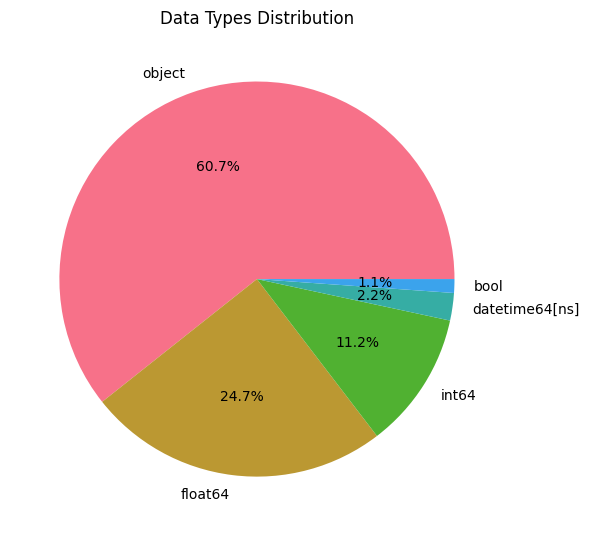

In [31]:
plot_data_type_distribution(df_lung)

### Missing Values

In [32]:
def plot_missing_data_bar(df):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    if not missing_counts.empty:
        missing_counts.plot(kind='bar', figsize=(28, 10))
        plt.title('Missing Values by Column')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values in dataset.")

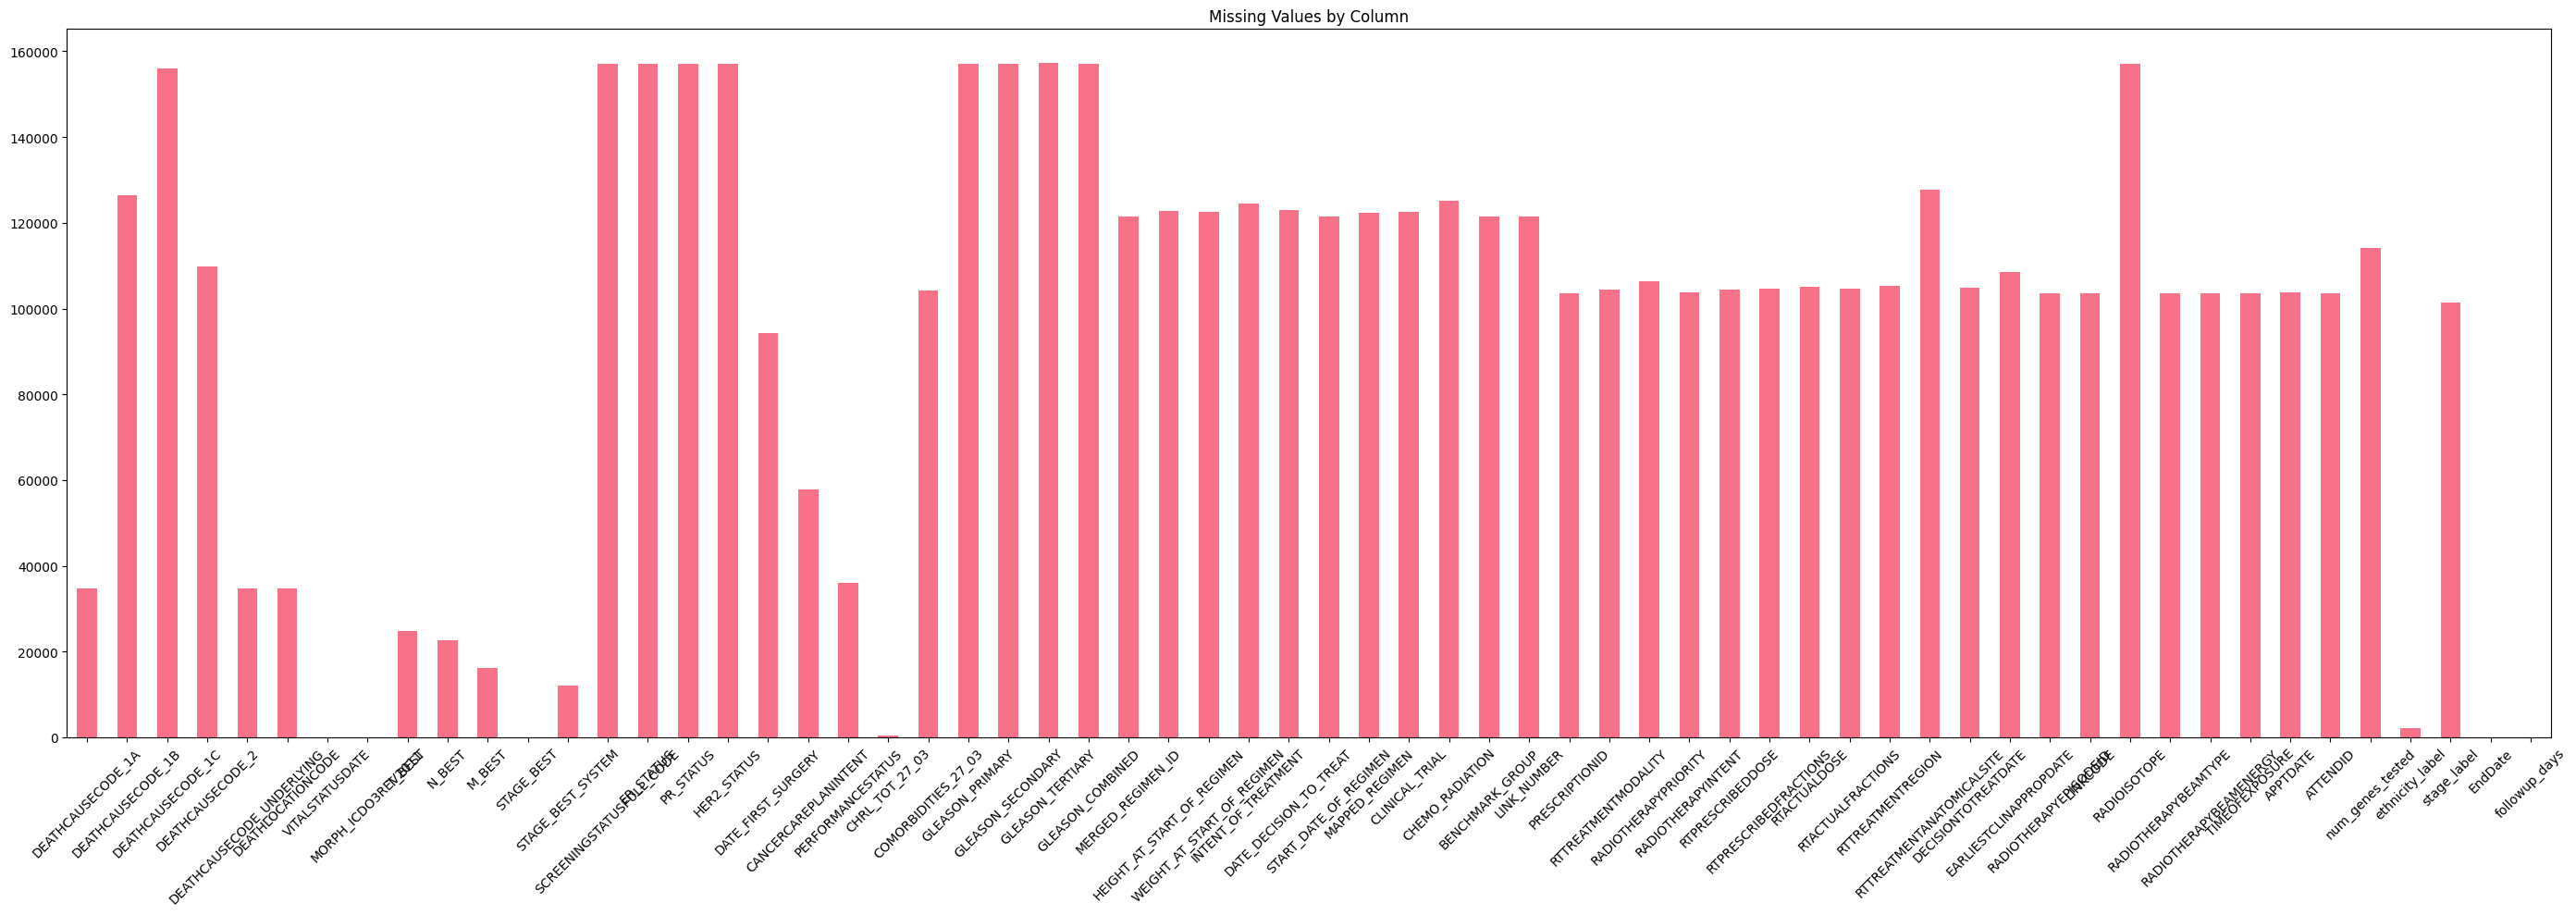

In [33]:
plot_missing_data_bar(df_lung)

### Correlation Matrix

In [34]:
df_lung.head()

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,...,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,...,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,...,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,...,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,...,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,...,2022-07-05,1018.0,0,False,Stage 4


In [35]:
def plot_correlation_heatmap(df, exclude=None, min_unique=2):
    exclude = exclude or []

    # Keep only numeric columns and drop the excluded list
    num_df = (
        df.drop(columns=exclude, errors="ignore")
          .select_dtypes(include=[np.number])
    )

    # Drop constant / near-constant columns
    num_df = num_df.loc[:, num_df.nunique() >= min_unique]

    if num_df.shape[1] < 2:
        print("Not enough numeric columns with variance for a correlation matrix.")
        return

    corr = num_df.corr()

    # Optional: show only lower triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(20, 16))
    sns.heatmap(
        corr, mask=mask, cmap='coolwarm', center=0,
        vmin=-1, vmax=1, linewidths=.5, annot=True, fmt=".2f"
    )
    plt.title("Correlation Matrix (variance-filtered)")
    plt.tight_layout()
    plt.show()


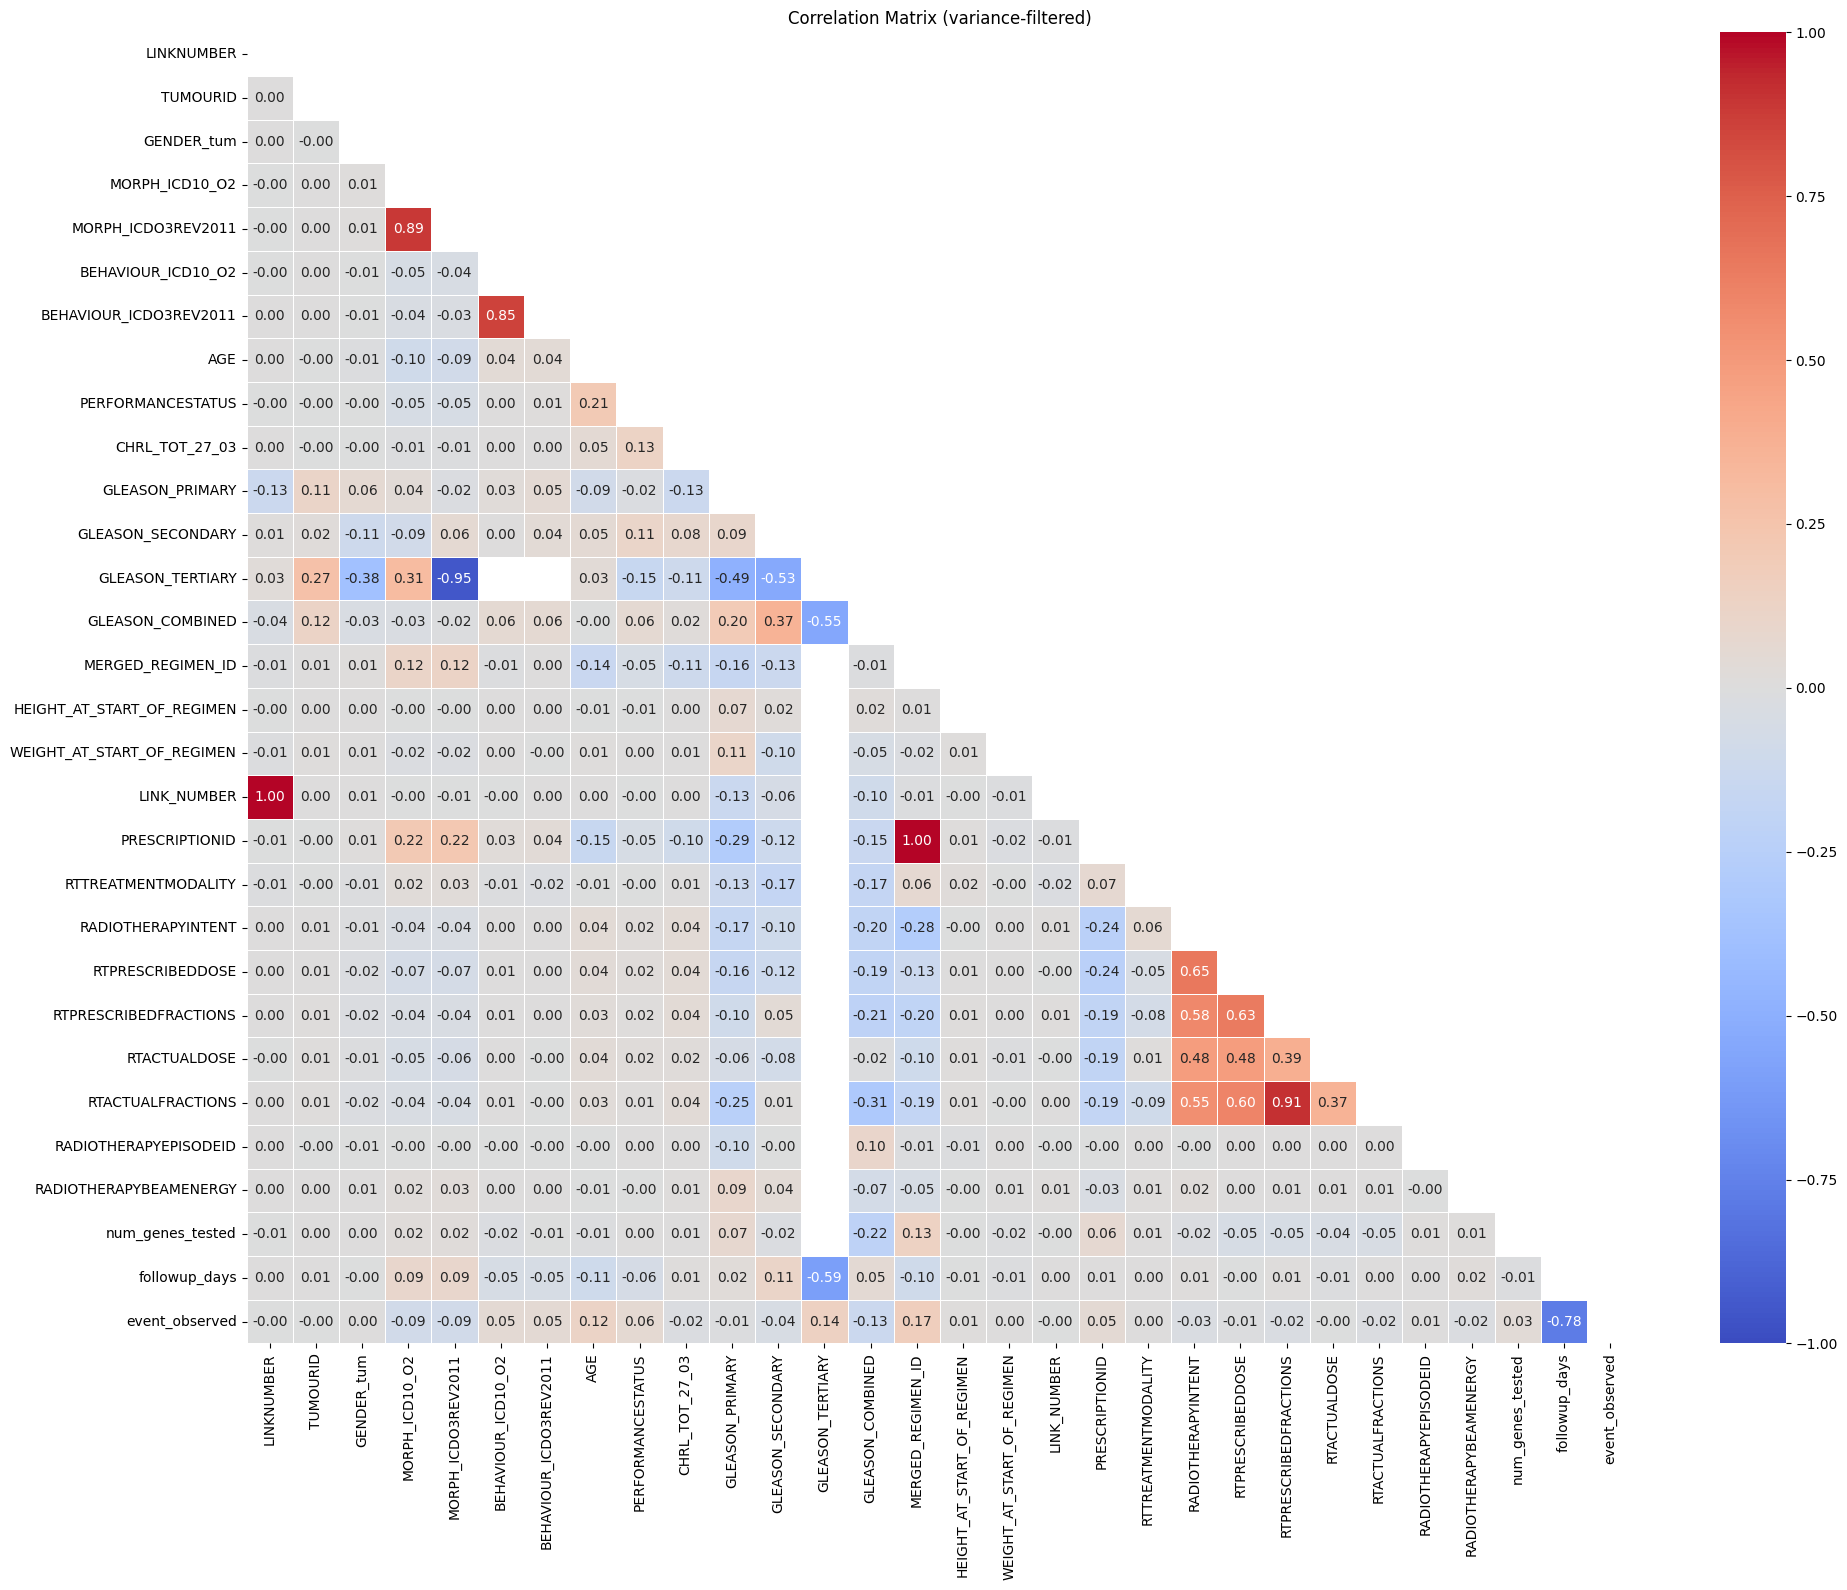

In [36]:
plot_correlation_heatmap(df_lung,exclude=["PATIENTID", "GENDER_pt"])

### Descriptive Stats

In [37]:
def descriptive_stats(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        display(df[numeric_cols].describe())

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        for col in categorical_cols[:5]:
            print(df[col].value_counts().head())

In [38]:
descriptive_stats(df_lung)

,PATIENTID,GENDER_pt,LINKNUMBER,TUMOURID,GENDER_tum,MORPH_ICD10_O2,MORPH_ICDO3REV2011,BEHAVIOUR_ICD10_O2,BEHAVIOUR_ICDO3REV2011,AGE,...,RADIOTHERAPYINTENT,RTPRESCRIBEDDOSE,RTPRESCRIBEDFRACTIONS,RTACTUALDOSE,RTACTUALFRACTIONS,RADIOTHERAPYEPISODEID,RADIOTHERAPYBEAMENERGY,num_genes_tested,followup_days,event_observed
count,1.573540e+05,157354.000000,1.573540e+05,1.573540e+05,157354.000000,157354.000000,157351.000000,157354.000000,157354.000000,157354.000000,...,53595.000000,52944.000000,52752.000000,52354.000000,52687.000000,5.382300e+04,53810.000000,43254.000000,157309.000000,157354.000000
mean,7.202901e+07,1.466426,1.009358e+08,1.099896e+07,1.466426,8105.410705,8110.994395,3.000114,3.000337,72.181451,...,1.586808,35.849482,11.234095,26.577912,10.698863,1.498705e+06,6.133924,1.746428,606.545461,0.783278
std,2.322634e+07,0.498873,5.401486e+05,5.776522e+05,0.498873,181.453431,191.509647,0.210253,0.202853,11.184095,...,0.509471,23.708596,10.167374,19.507550,10.199251,2.895532e+05,5.673671,0.834941,665.908504,0.412013
min,1.017521e+07,1.000000,1.000000e+08,1.000000e+07,1.000000,8000.000000,8000.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,-45.962824,1.000000,1.000013e+06,0.000000,1.000000,0.000000,0.000000
25%,6.003354e+07,1.000000,1.004679e+08,1.049704e+07,1.000000,8010.000000,8010.000000,3.000000,3.000000,66.000000,...,1.000000,20.000000,3.000000,10.000000,2.000000,1.244588e+06,6.000000,1.000000,62.000000,1.000000
50%,6.007287e+07,1.000000,1.009362e+08,1.099828e+07,1.000000,8070.000000,8070.000000,3.000000,3.000000,73.000000,...,2.000000,35.000000,5.000000,20.000000,5.000000,1.500280e+06,6.000000,2.000000,290.000000,1.000000
75%,1.000089e+08,2.000000,1.014026e+08,1.149960e+07,2.000000,8140.000000,8140.000000,3.000000,3.000000,80.000000,...,2.000000,55.000000,20.000000,39.000000,20.000000,1.749195e+06,6.000000,2.000000,1073.000000,1.000000
max,2.500025e+08,2.000000,1.018716e+08,1.200000e+07,2.000000,9989.000000,9989.000000,9.000000,9.000000,107.000000,...,3.000000,2200.000000,60.000000,1118.000000,72.000000,1.999997e+06,380.000000,18.000000,2377.000000,1.000000


DEATHCAUSECODE_1A
C349    70914
J189     8127
J180     3951
C798     3582
J22      1663
Name: count, dtype: int64
DEATHCAUSECODE_1B
C349    15517
J449     1555
J189      775
I259      397
I251      351
Name: count, dtype: int64
DEATHCAUSECODE_1C
C349    461
F179     60
J449     52
I259     38
J189     23
Name: count, dtype: int64
DEATHCAUSECODE_2
J449    6764
C349    3470
I259    1494
I10      682
E119     637
Name: count, dtype: int64
DEATHCAUSECODE_UNDERLYING
C349    99228
C809     1408
J440     1282
C800     1146
U071     1107
Name: count, dtype: int64


In [39]:
assert 'PATIENTID' in df_lung.columns, "df_lung must have PATIENTID"
print("df_lung rows:", len(df_lung))
print("columns:", df_lung.columns.tolist()[:12], "...")

df_lung rows: 157354
columns: ['PATIENTID', 'GENDER_pt', 'DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2', 'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS', 'VITALSTATUSDATE', 'LINKNUMBER', 'TUMOURID'] ...


In [40]:
for expected in ['gender_label', 'ethnicity_label', 'stage_label']:
    if expected not in df_lung.columns:
        print(f"⚠️  Warning: {expected} missing – check earlier merge step")

# Simplify stage if Stage_Group not yet created
if 'Stage_Group' not in df_lung.columns:
    def simplify_stage(code, label):
        return label if pd.notnull(label) else f"Stage {str(code)[0]}"
    df_lung['Stage_Group'] = df_lung.apply(
        lambda row: simplify_stage(row['STAGE_BEST'], row.get('stage_label')),
        axis=1
    )

# Dataset v2

In [41]:
df_surv = df_lung.copy()

df_surv['DiagDate'] = pd.to_datetime(df_surv['DIAGNOSISDATEBEST'])
df_surv['EndDate']  = pd.to_datetime(df_surv['VITALSTATUSDATE'])
df_surv['followup_days'] = (df_surv['EndDate'] - df_surv['DiagDate']).dt.days.clip(lower=0)
df_surv['event_observed'] = (df_surv['VITALSTATUS'] == 'D').astype(int)

df_surv = df_surv[df_surv['followup_days'].notna() & (df_surv['followup_days'] >= 0)]

### Demographic Plots

In [42]:
def plot_counts(data, column, title, xlabel):
    sns.countplot(data=data, x=column, order=data[column].value_counts().index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

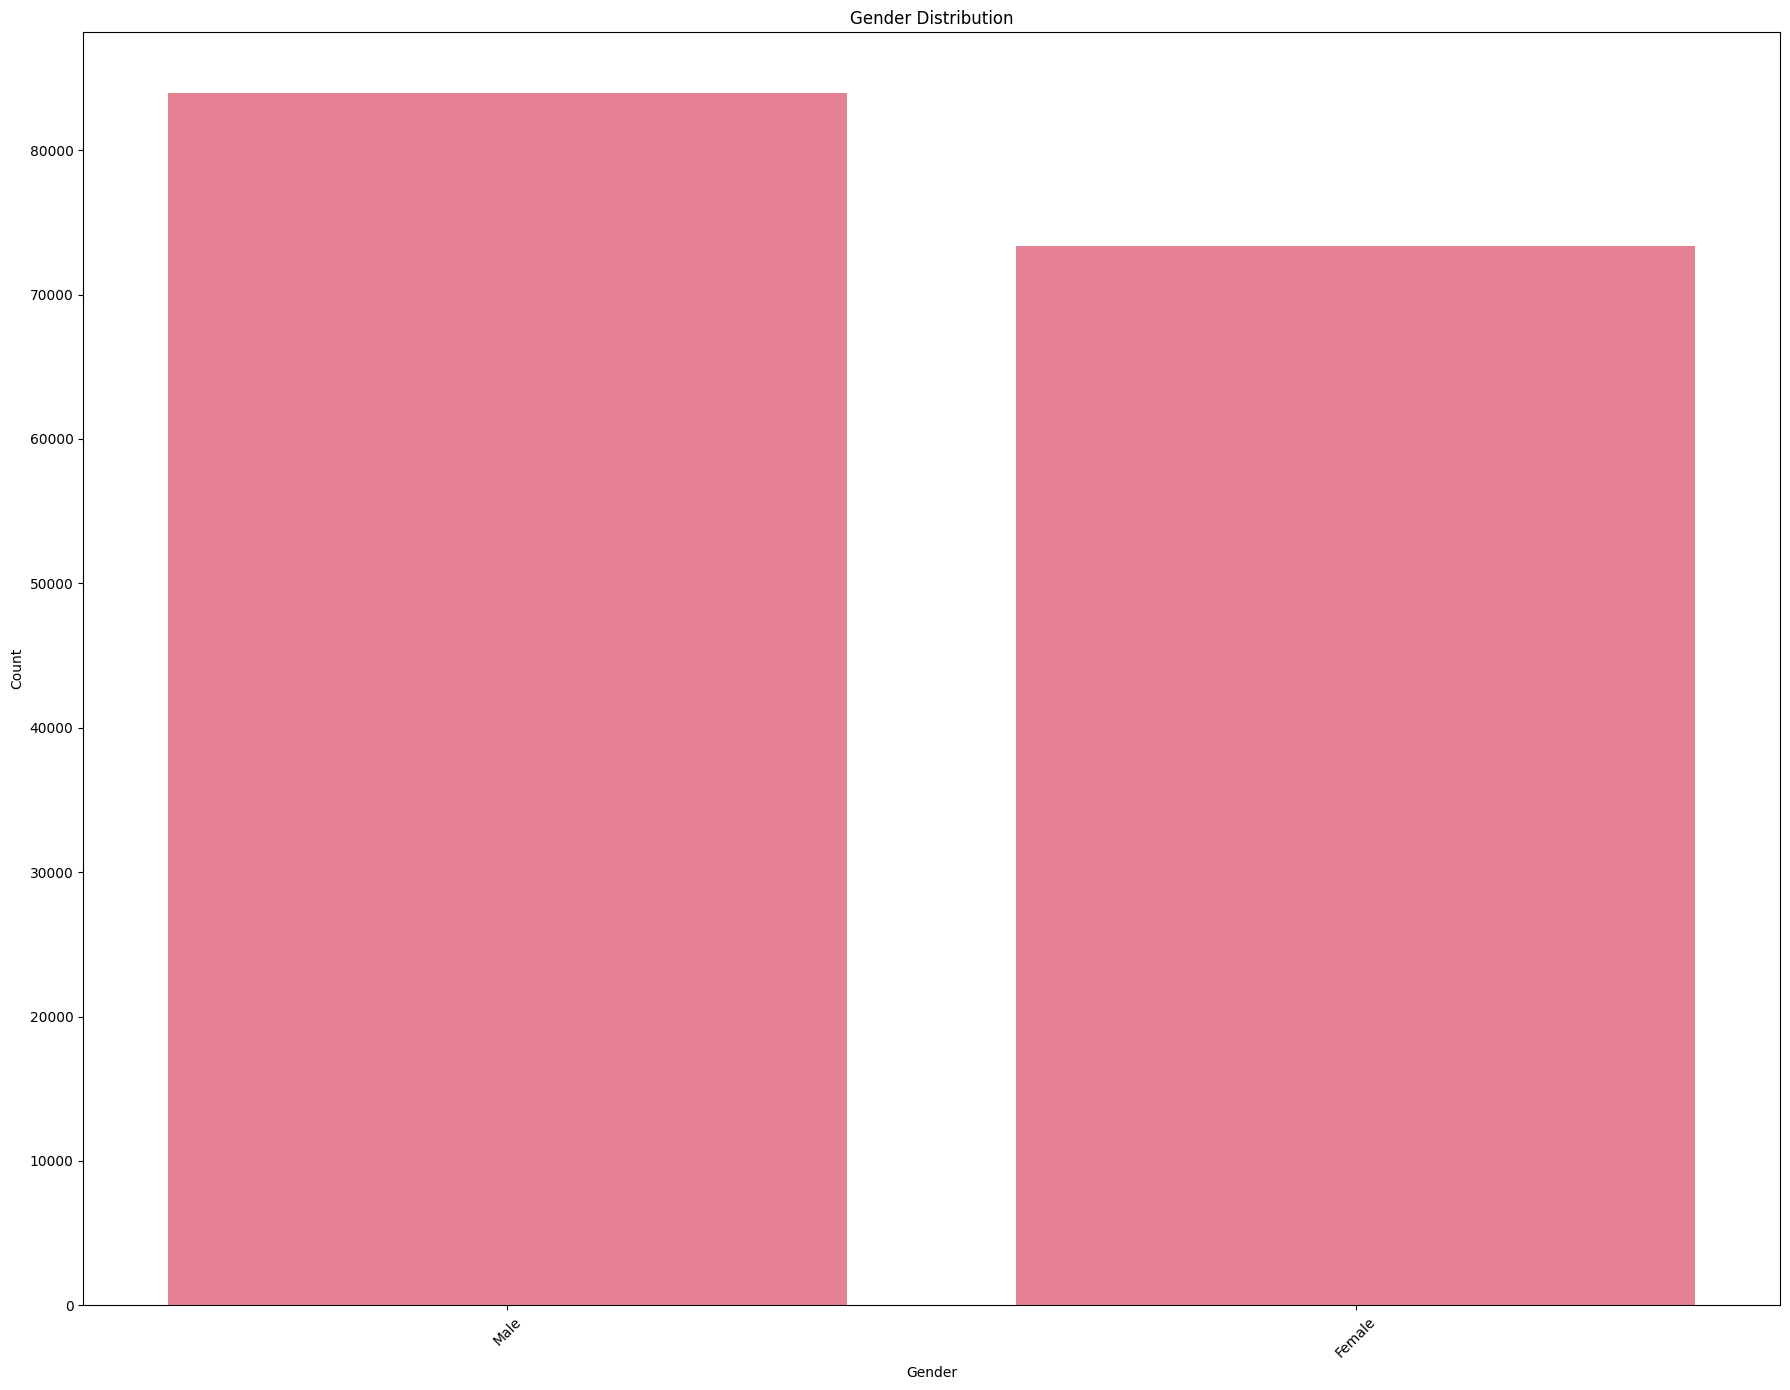

In [43]:
plot_counts(df_lung, "gender_label", "Gender Distribution", "Gender")

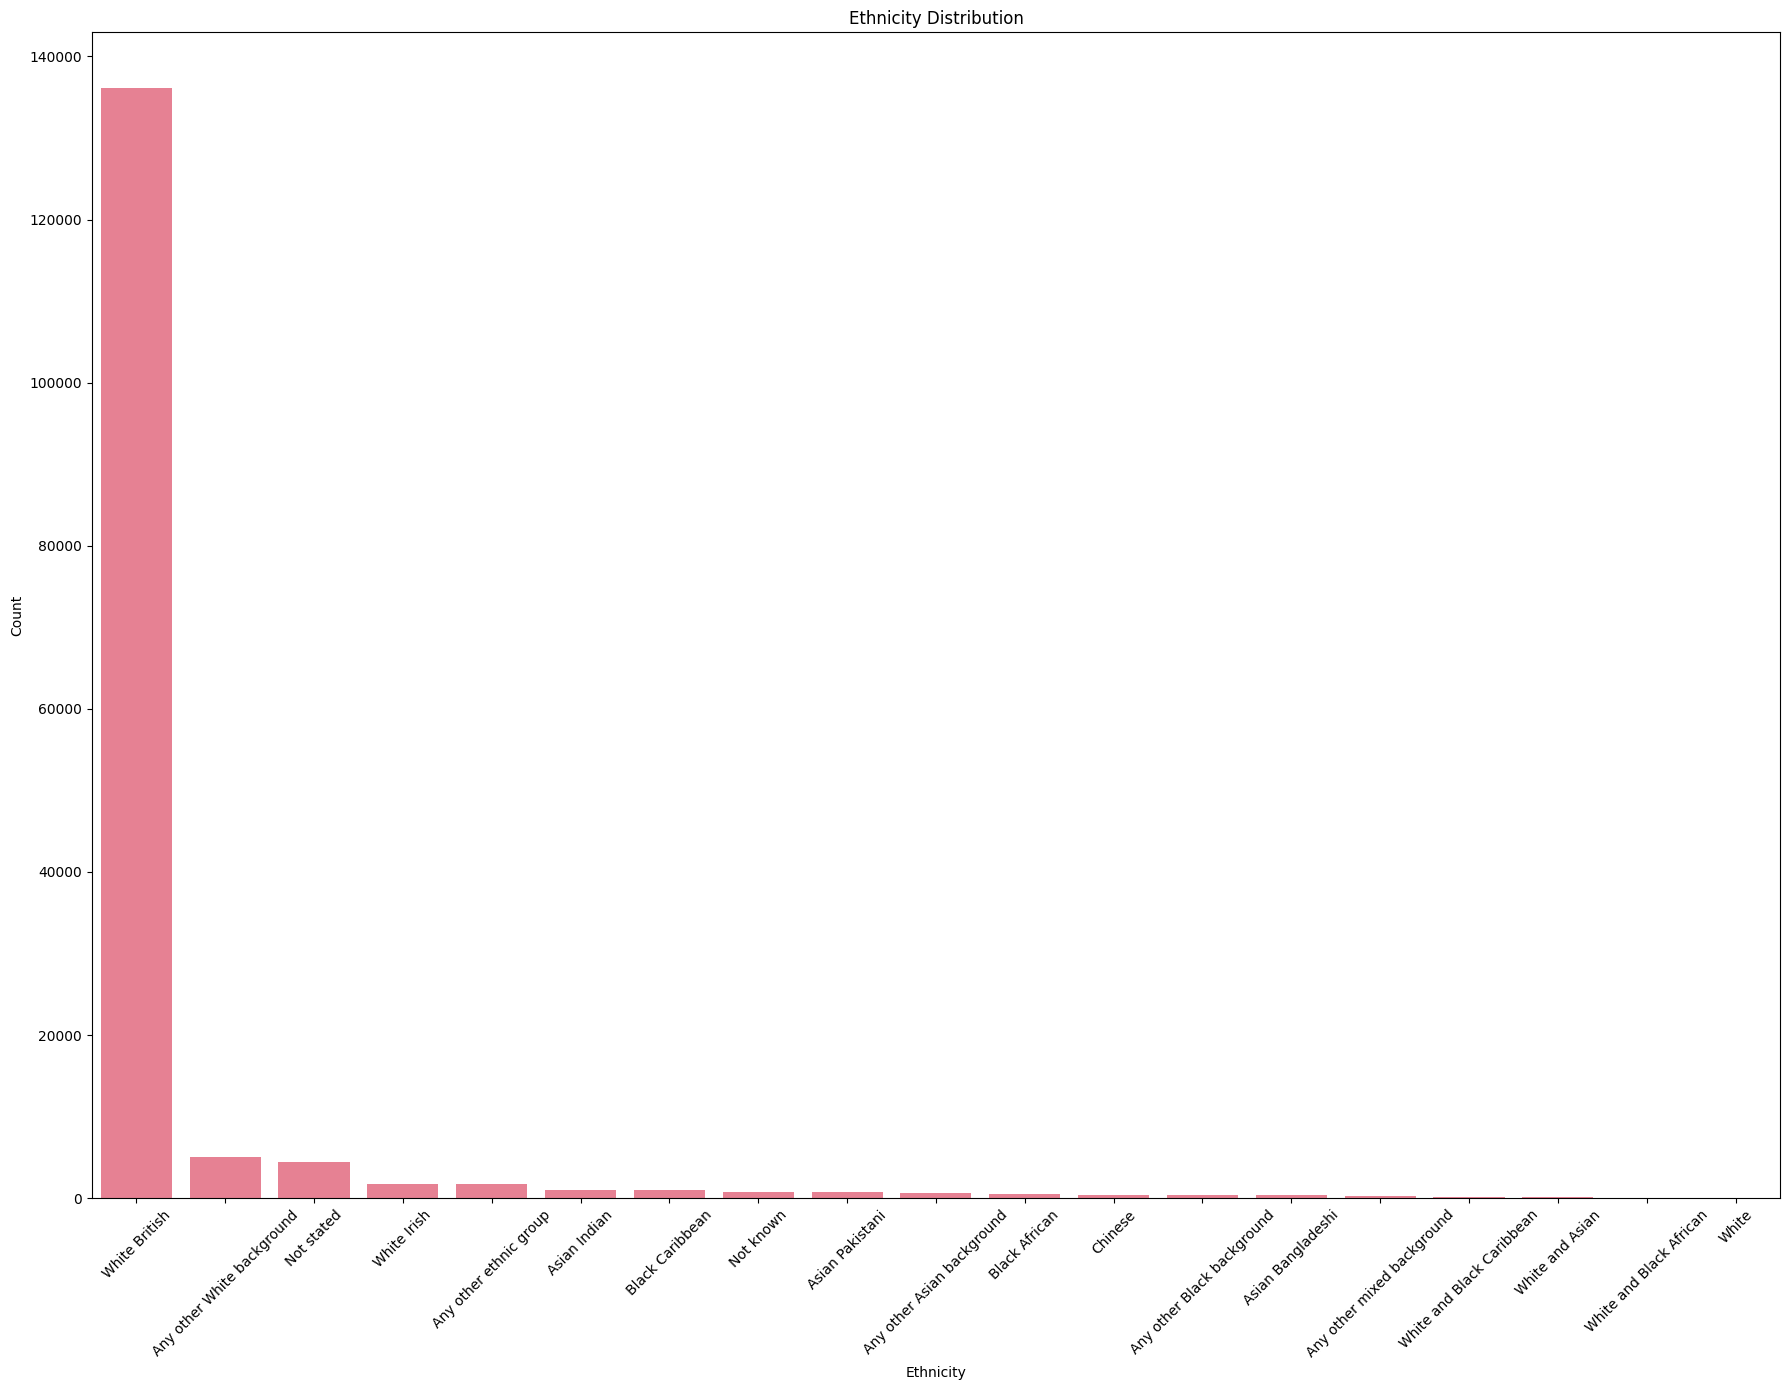

In [44]:
plot_counts(df_lung, "ethnicity_label", "Ethnicity Distribution", "Ethnicity")

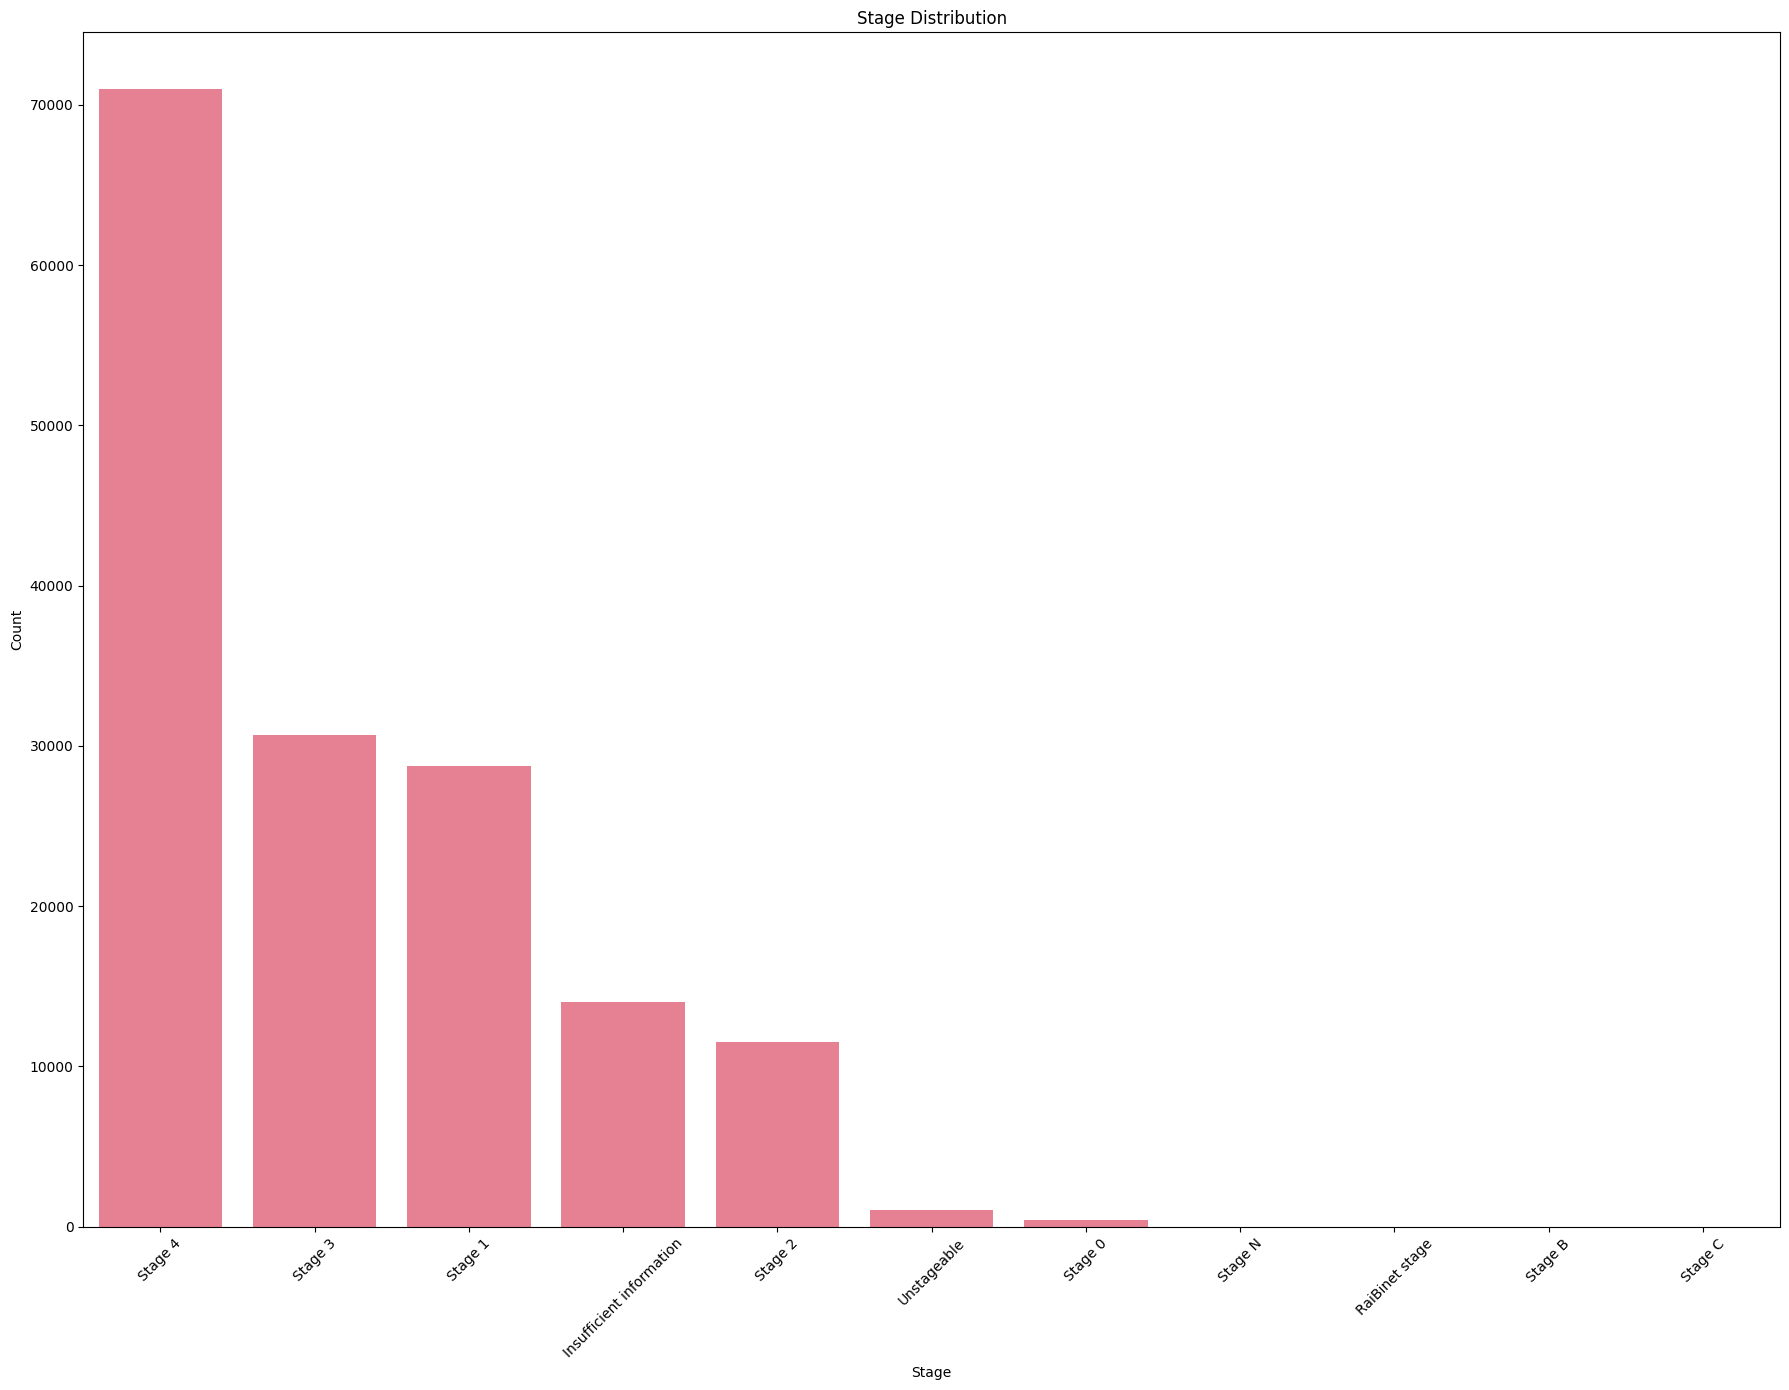

In [45]:
plot_counts(df_lung, "Stage_Group", "Stage Distribution", "Stage")

### Age Distribution at Diagnosis

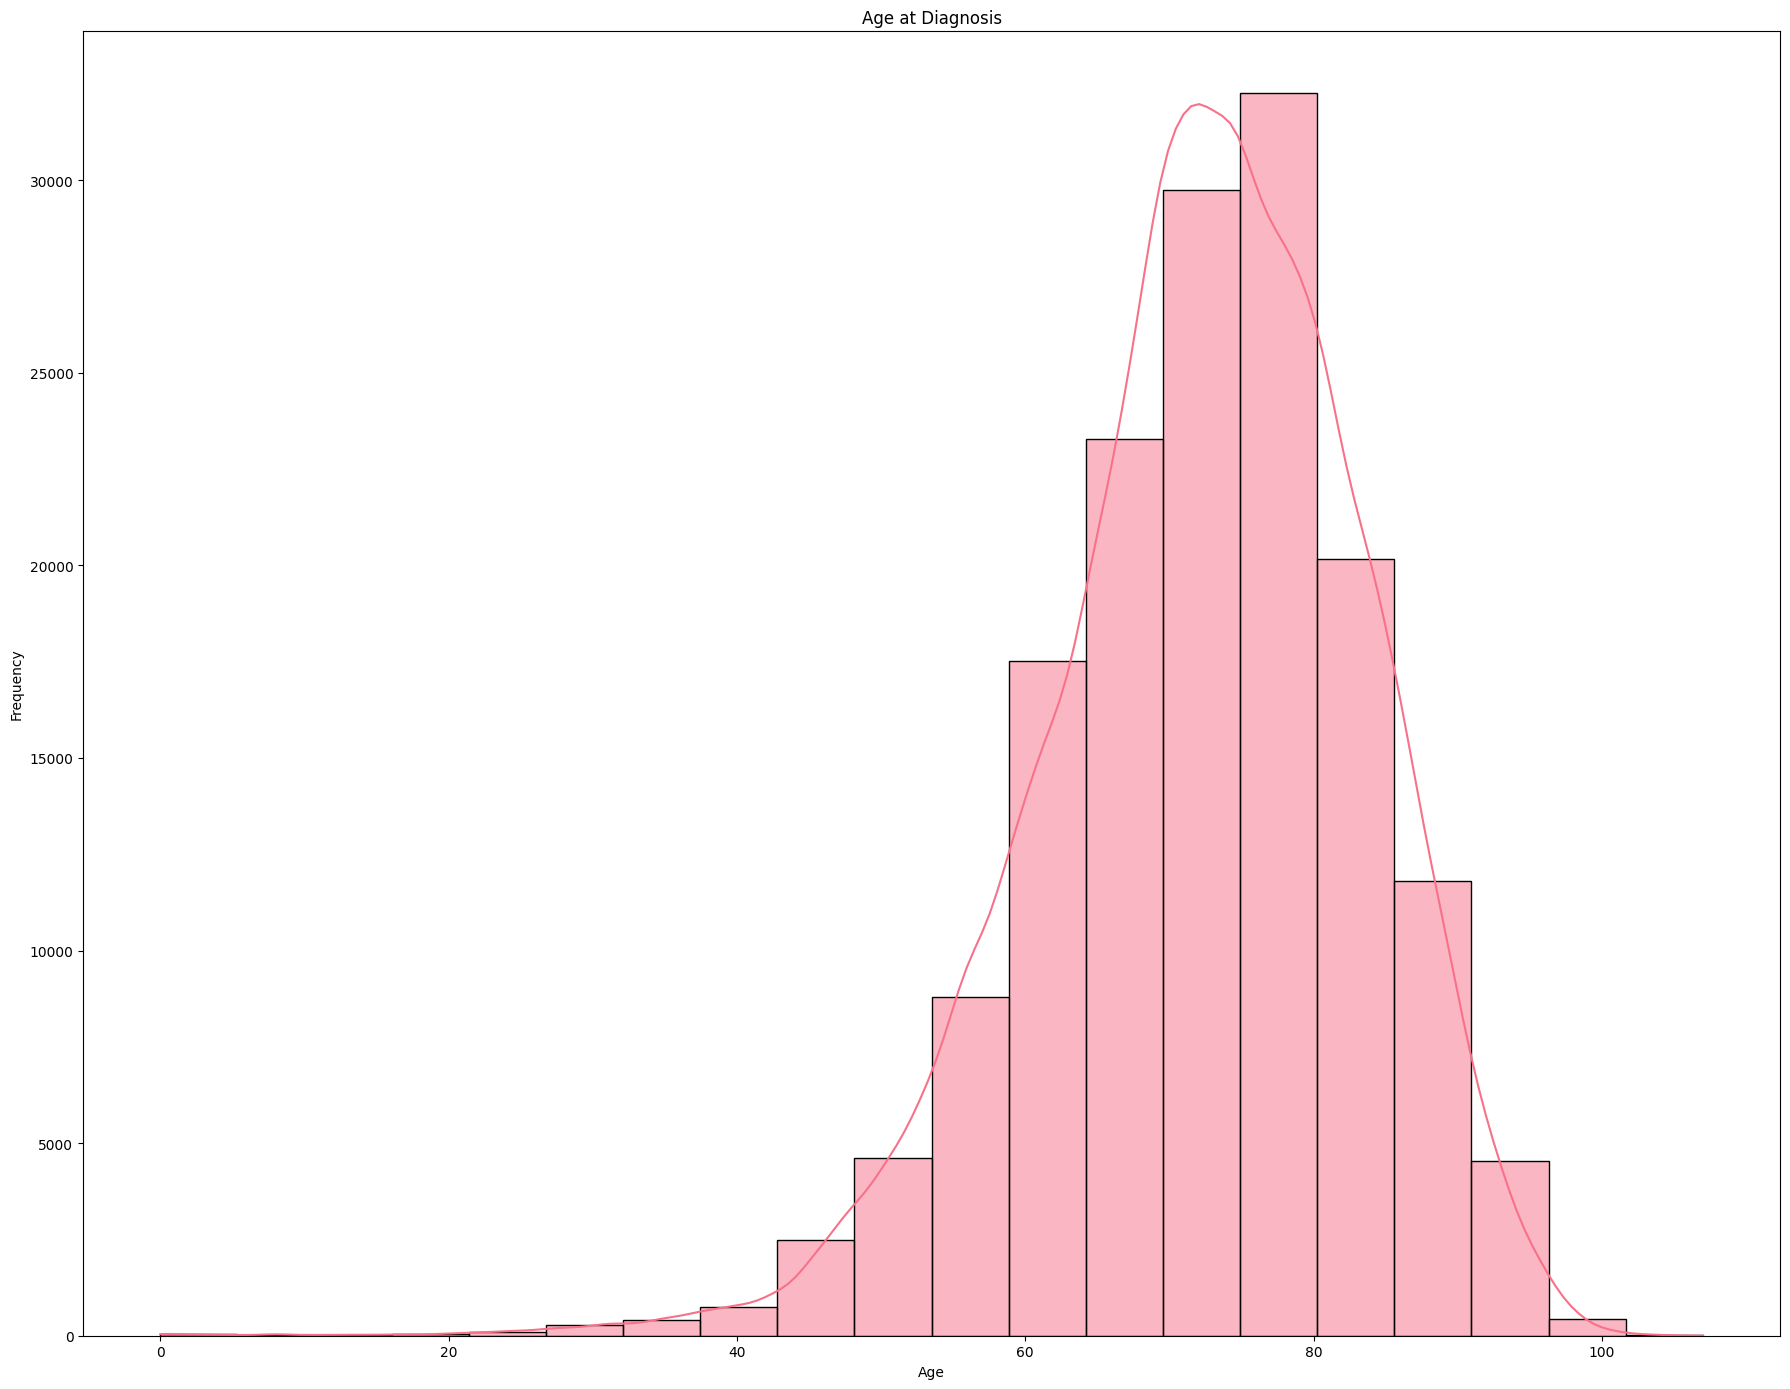

In [46]:
sns.histplot(df_lung["AGE"].dropna(), bins=20, kde=True)
plt.title("Age at Diagnosis")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

###  KAPLAN–MEIER

In [47]:
kmf = KaplanMeierFitter()

#### Overall

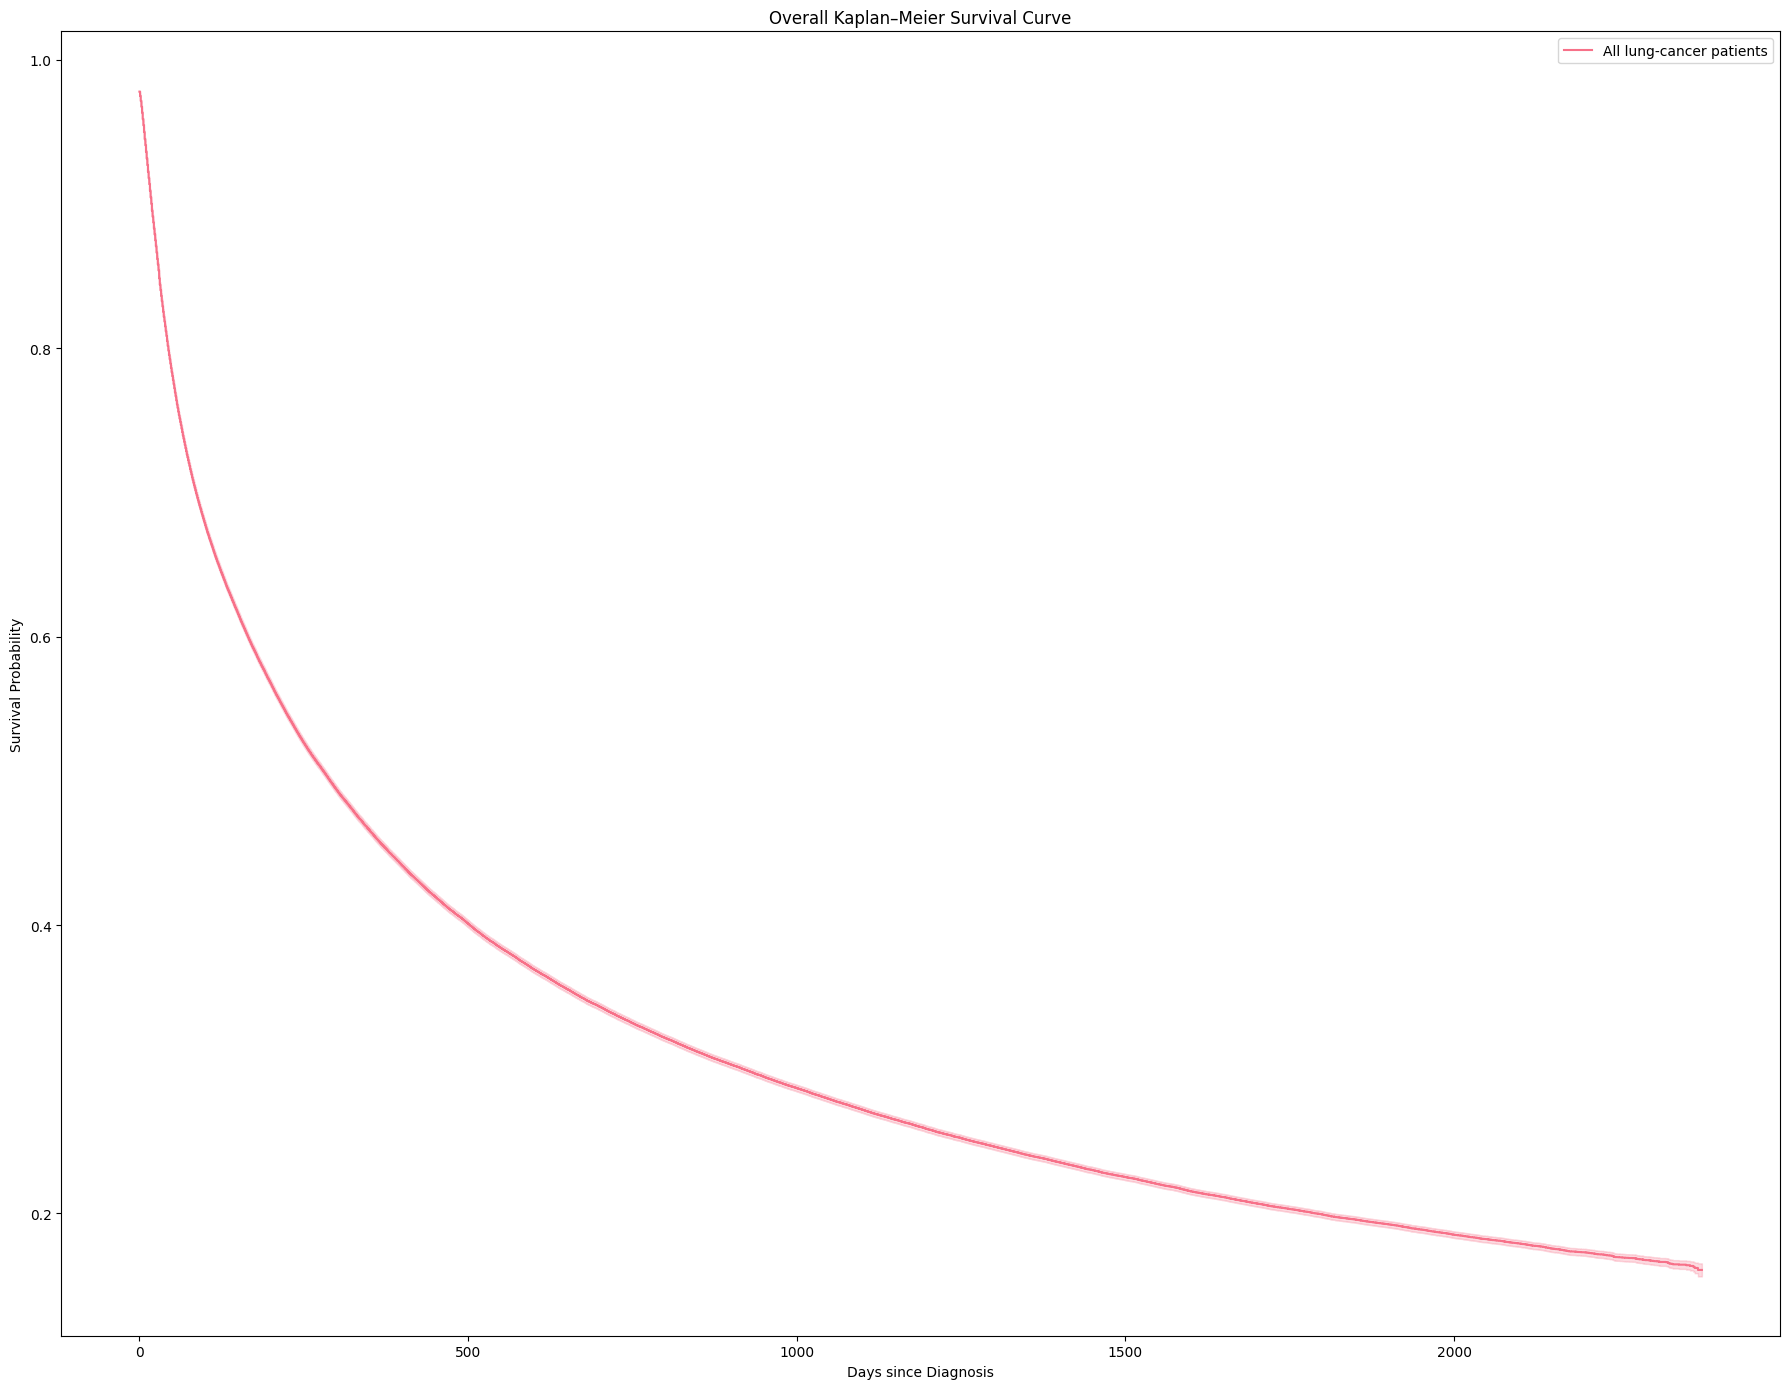

In [48]:
kmf.fit(df_surv['followup_days'], event_observed=df_surv['event_observed'],
        label="All lung-cancer patients")
kmf.plot_survival_function(ci_show=True)
plt.title("Overall Kaplan–Meier Survival Curve")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()

#### By Tumour Stage

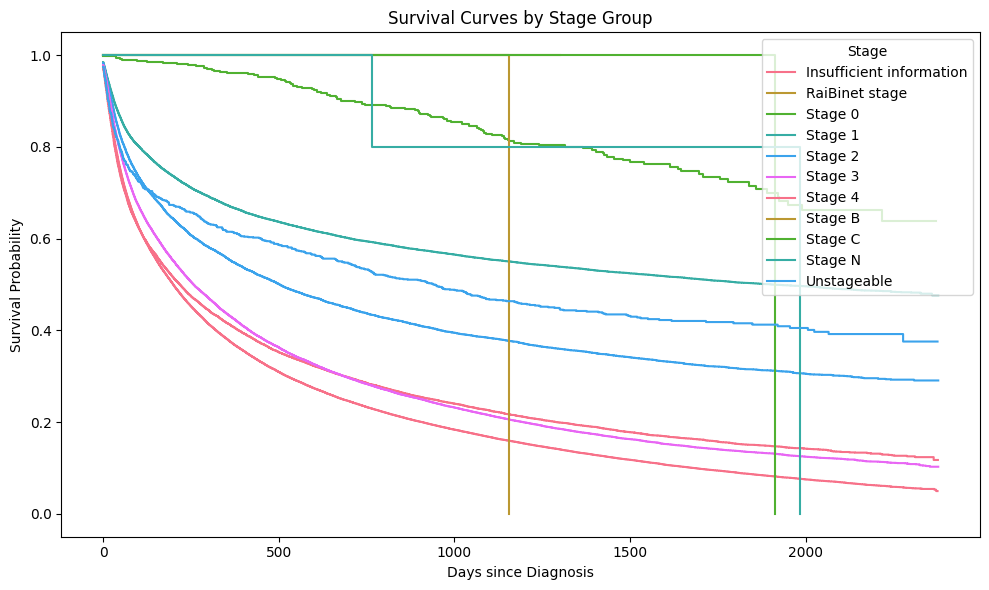

In [49]:
plt.figure(figsize=(10, 6))
for stage, grp in df_surv.dropna(subset=['Stage_Group']).groupby('Stage_Group'):
    kmf.fit(grp['followup_days'], grp['event_observed'], label=stage)
    kmf.plot_survival_function(ci_show=False)
plt.title("Survival Curves by Stage Group")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.legend(title="Stage")
plt.tight_layout()
plt.show()

### Stage & Genetic Testing Status

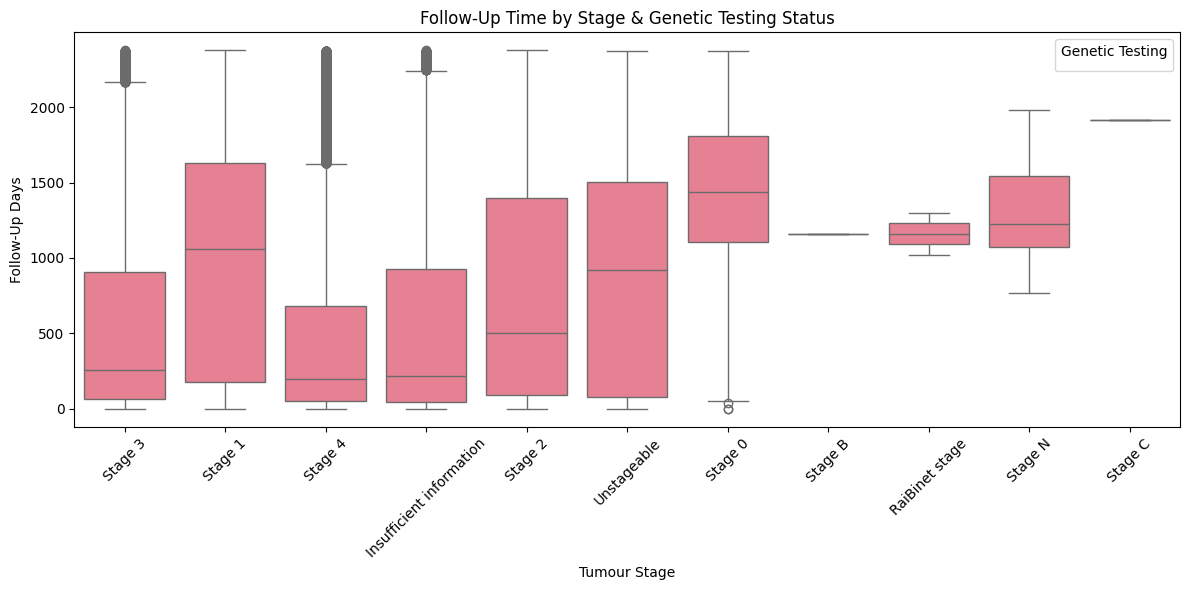

In [50]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_surv, x='Stage_Group', y='followup_days')
plt.title("Follow-Up Time by Stage & Genetic Testing Status")
plt.xlabel("Tumour Stage")
plt.ylabel("Follow-Up Days")
plt.xticks(rotation=45)
plt.legend(title="Genetic Testing")
plt.tight_layout()
plt.show()

### Radiotherapy Uptake

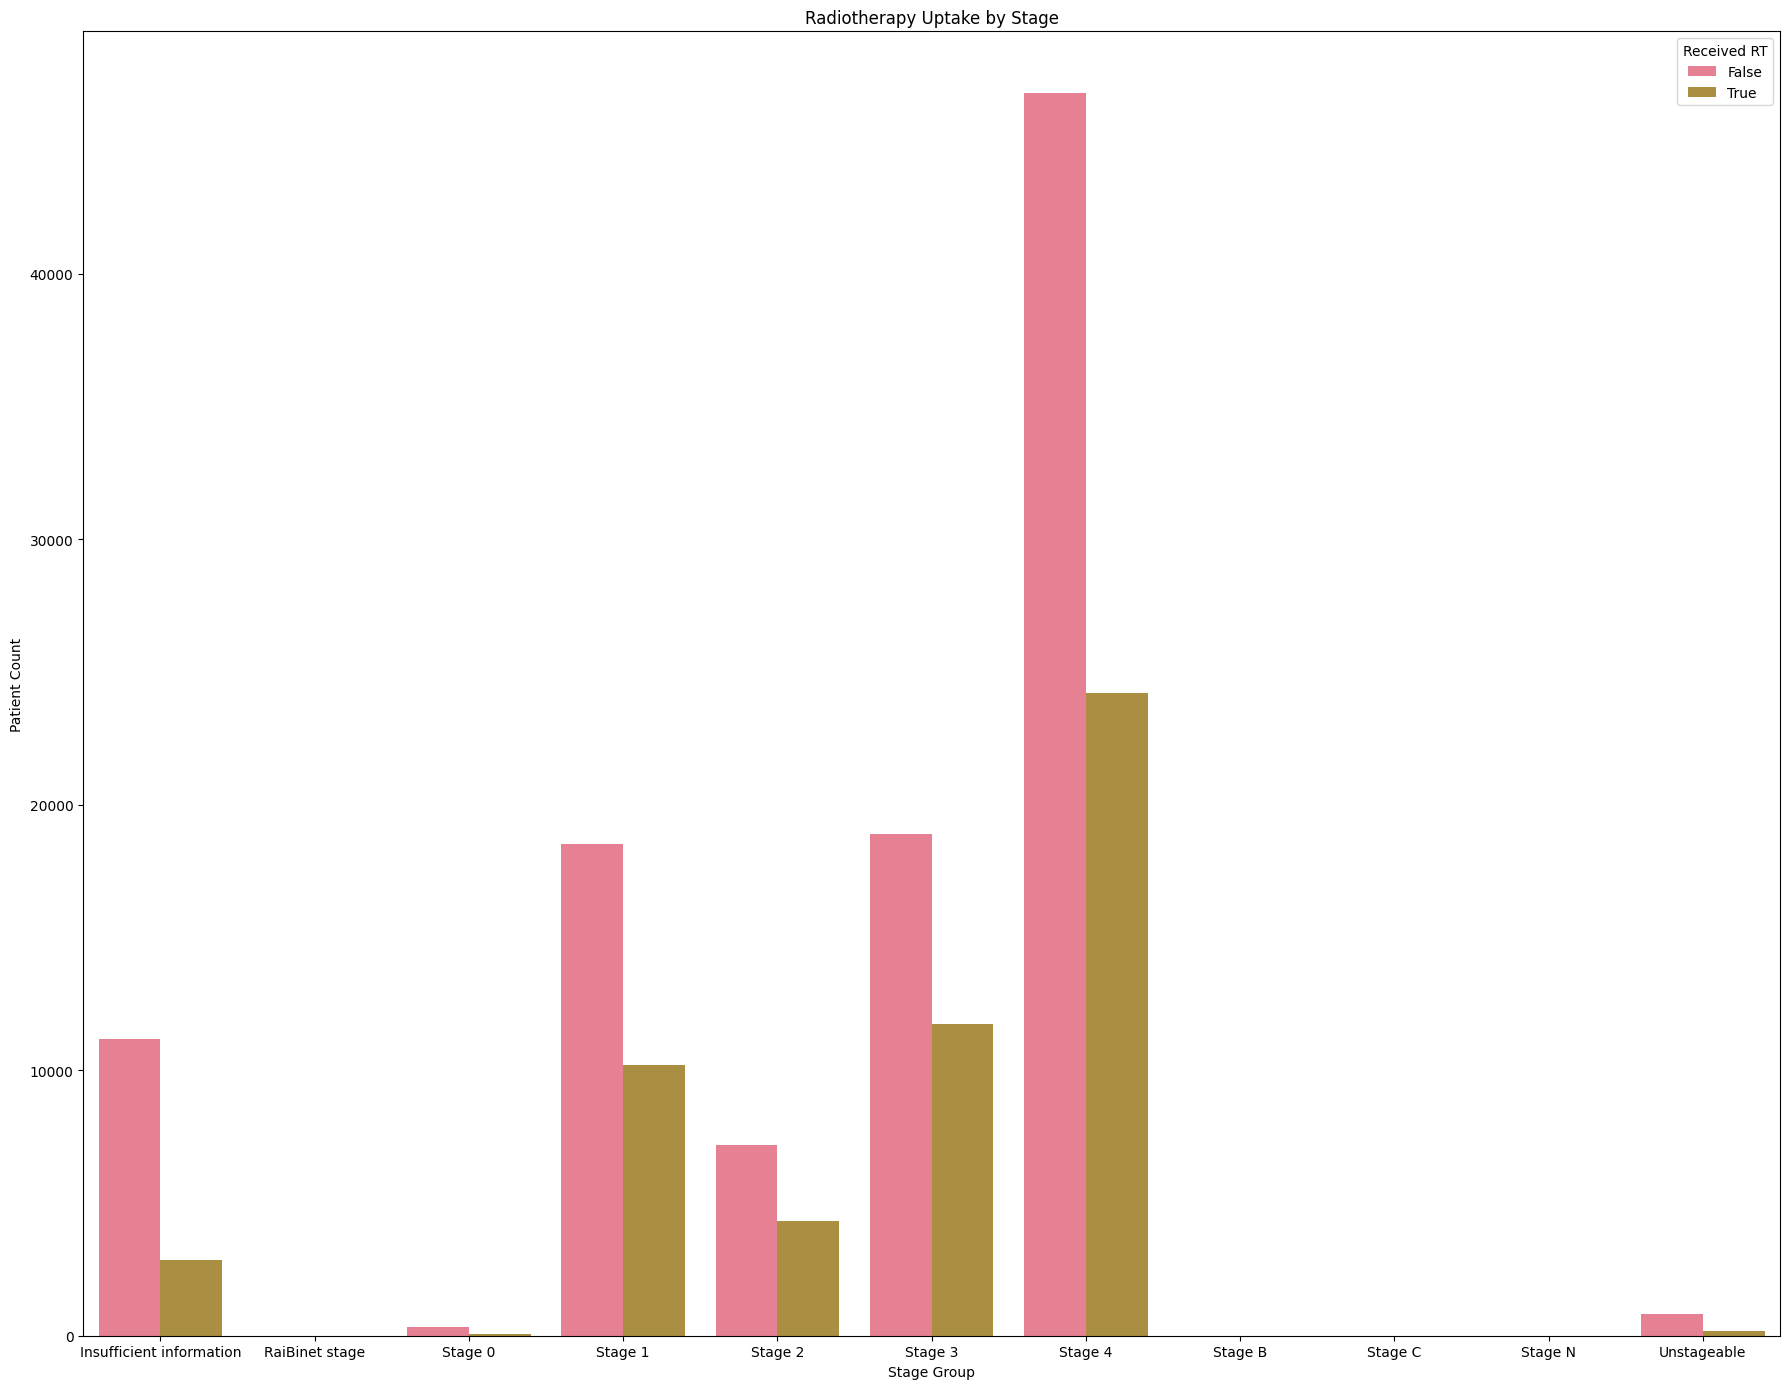

In [51]:
# 1.  Add human-readable intent label  (once only)
if 'rt_label' not in df_lung.columns:
    rt_intent_lookup = (
        pd.read_excel(LOOKUP_XLS, sheet_name="z_radiotherapyintent")
          .rename(columns={'Code': 'RADIOTHERAPYINTENT',
                           'Description': 'rt_label'})
    )
    df_lung = df_lung.merge(rt_intent_lookup,
                            on='RADIOTHERAPYINTENT',
                            how='left')

# 2.  Flag patients who received any radiotherapy row
df_lung['received_rt'] = df_lung['RADIOTHERAPYINTENT'].notna()

# 3-A.  Uptake by Stage (countplot)
sns.countplot(data=df_lung, x='Stage_Group', hue='received_rt',
              order=sorted(df_lung['Stage_Group'].unique()))
plt.title("Radiotherapy Uptake by Stage")
plt.xlabel("Stage Group")
plt.ylabel("Patient Count")
plt.legend(title="Received RT")
plt.tight_layout()
plt.show()

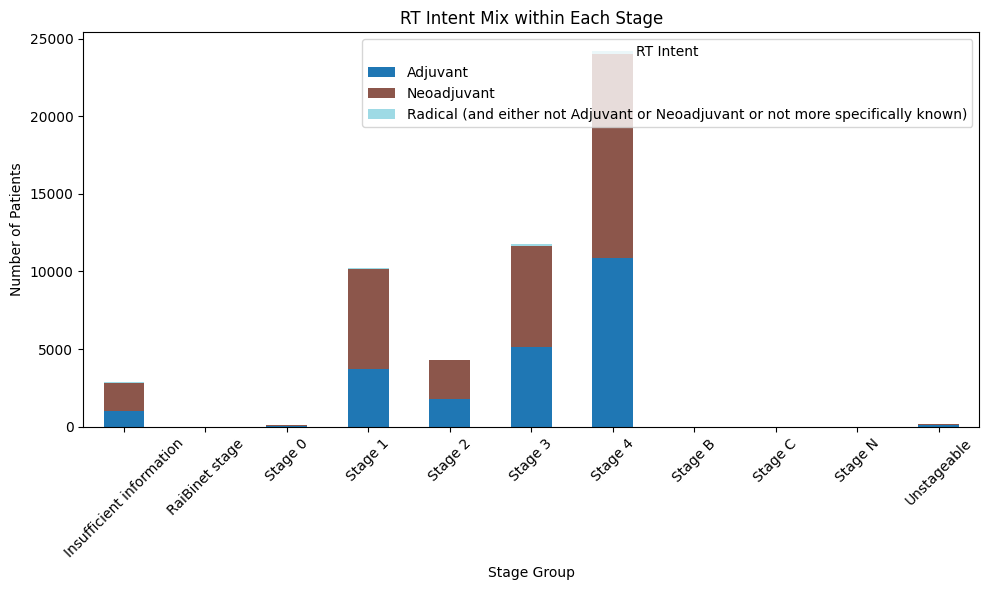

In [52]:
# 3-B.  Uptake by Intent type (stacked bar)
rt_counts = (df_lung[df_lung['received_rt']]
             .groupby(['Stage_Group', 'rt_label'])
             .size()
             .unstack(fill_value=0)
             .reindex(sorted(df_lung['Stage_Group'].unique())))
rt_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("RT Intent Mix within Each Stage")
plt.xlabel("Stage Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.legend(title="RT Intent")
plt.tight_layout()
plt.show()


### Systemic Anti-Cancer Therapy (SACT) Uptake

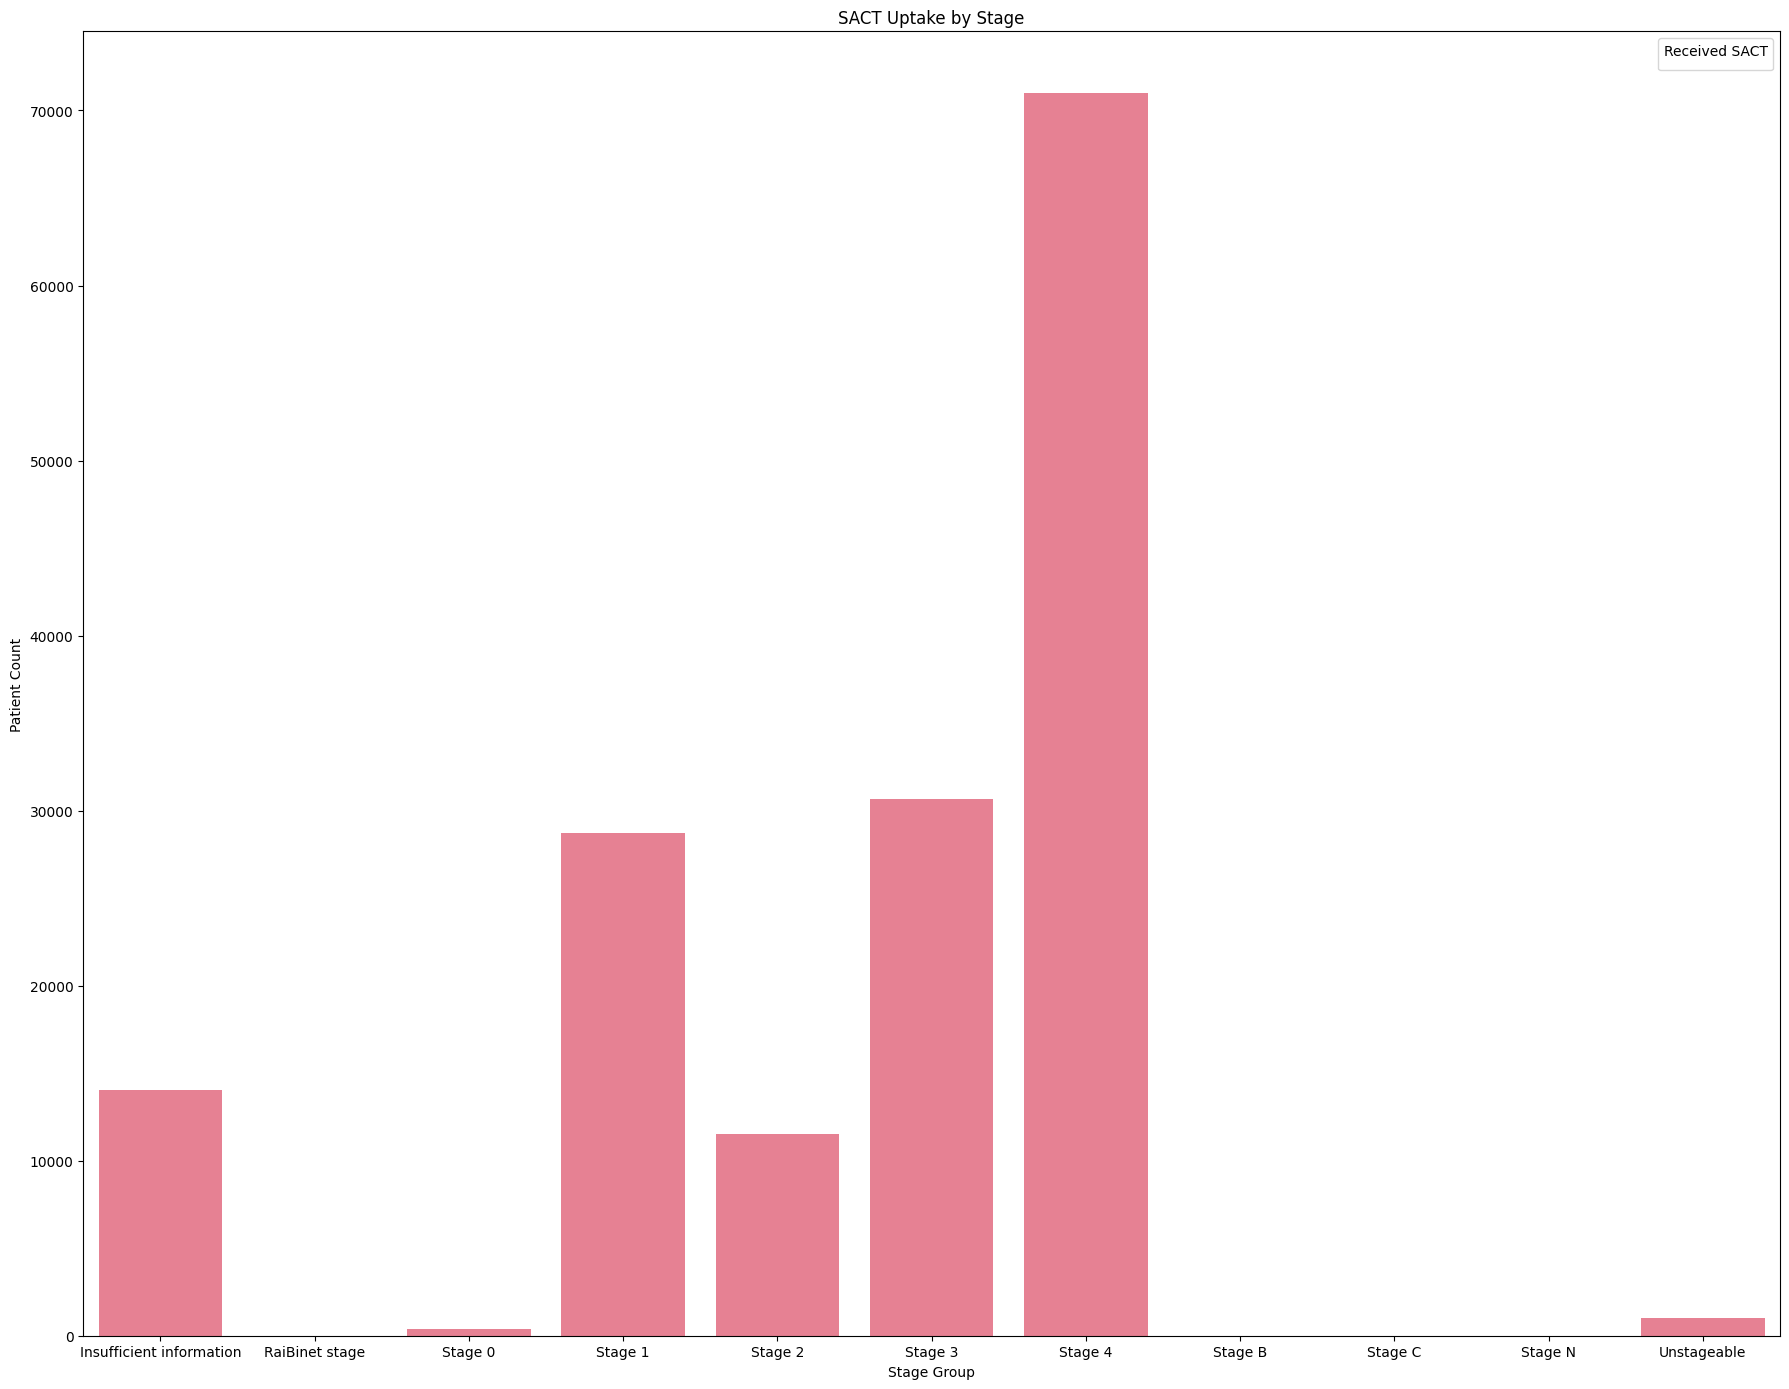

In [53]:
sns.countplot(
    data=df_lung,
    x='Stage_Group',
    # hue='received_sact',
    order=sorted(df_lung['Stage_Group'].unique())
)
plt.title("SACT Uptake by Stage")
plt.xlabel("Stage Group")
plt.ylabel("Patient Count")
plt.legend(title="Received SACT")
plt.tight_layout()
plt.show()

### Gene Testing Analysis

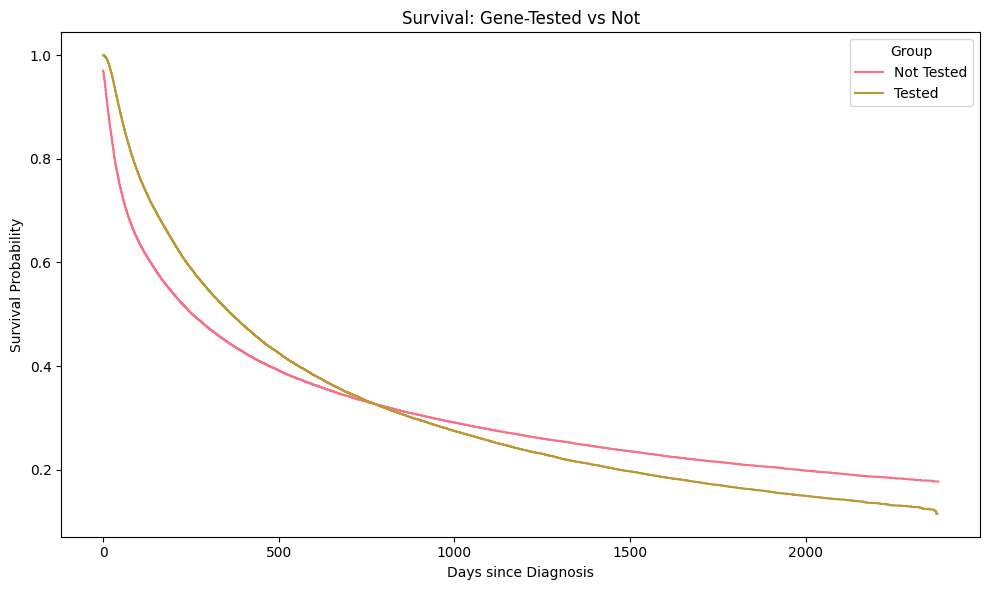

In [54]:
df_surv['tested_group'] = np.where(df_surv['num_genes_tested'] > 0, 'Tested', 'Not Tested')

plt.figure(figsize=(10, 6))
for lbl, grp in df_surv.groupby('tested_group'):
    kmf.fit(grp['followup_days'], grp['event_observed'], label=lbl)
    kmf.plot_survival_function(ci_show=False)
plt.title("Survival: Gene-Tested vs Not")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.legend(title="Group")
plt.tight_layout()
plt.show()

### Death Rate by Stage

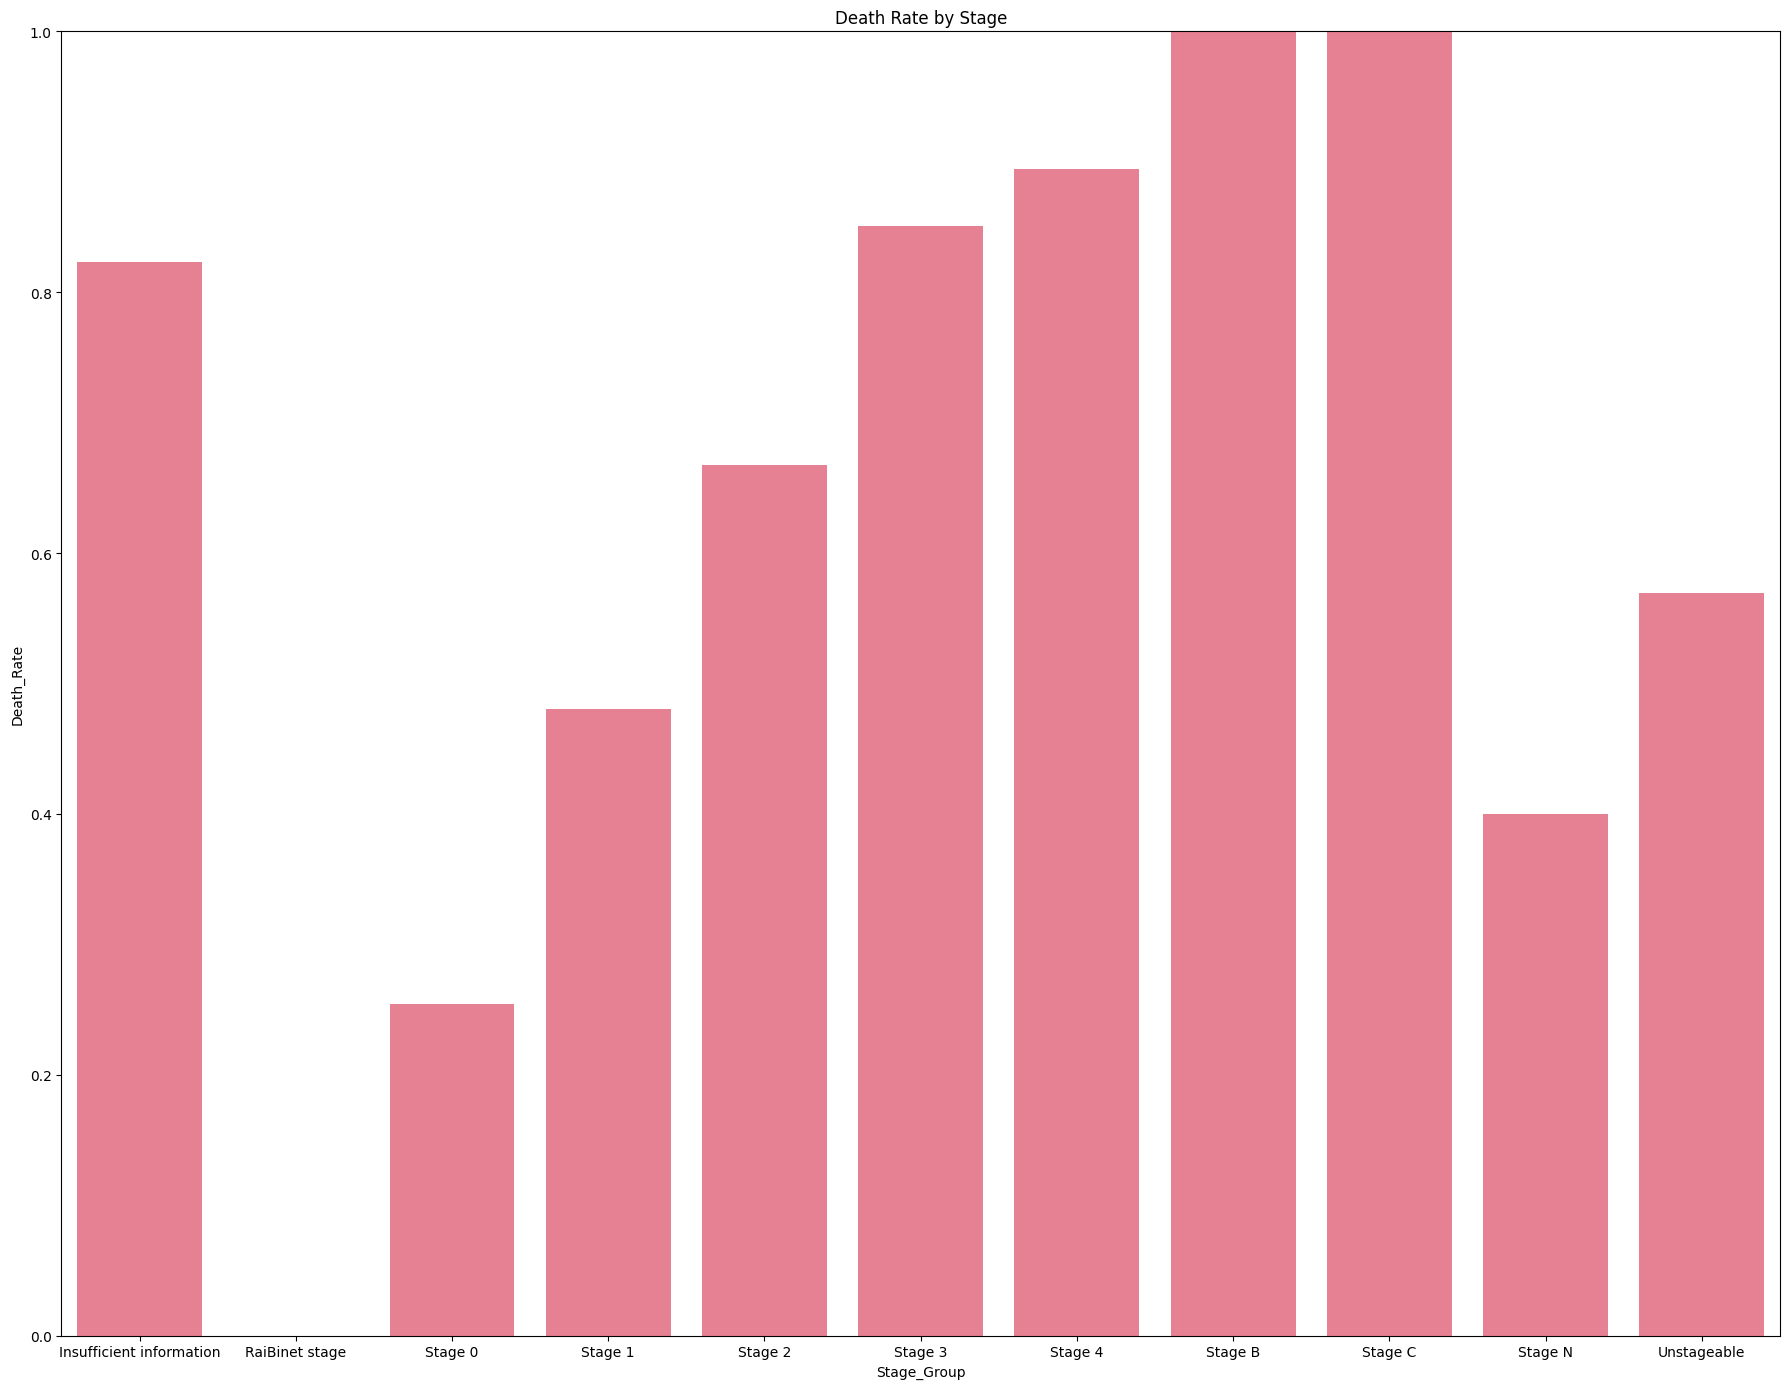

In [55]:
death_rate = (df_surv.groupby('Stage_Group')['event_observed'].mean().reset_index().rename(columns={'event_observed':'Death_Rate'}))

sns.barplot(data=death_rate, x='Stage_Group', y='Death_Rate', order=death_rate['Stage_Group'])
plt.title("Death Rate by Stage")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Follow-up Time Distribution by Stage & Event Status

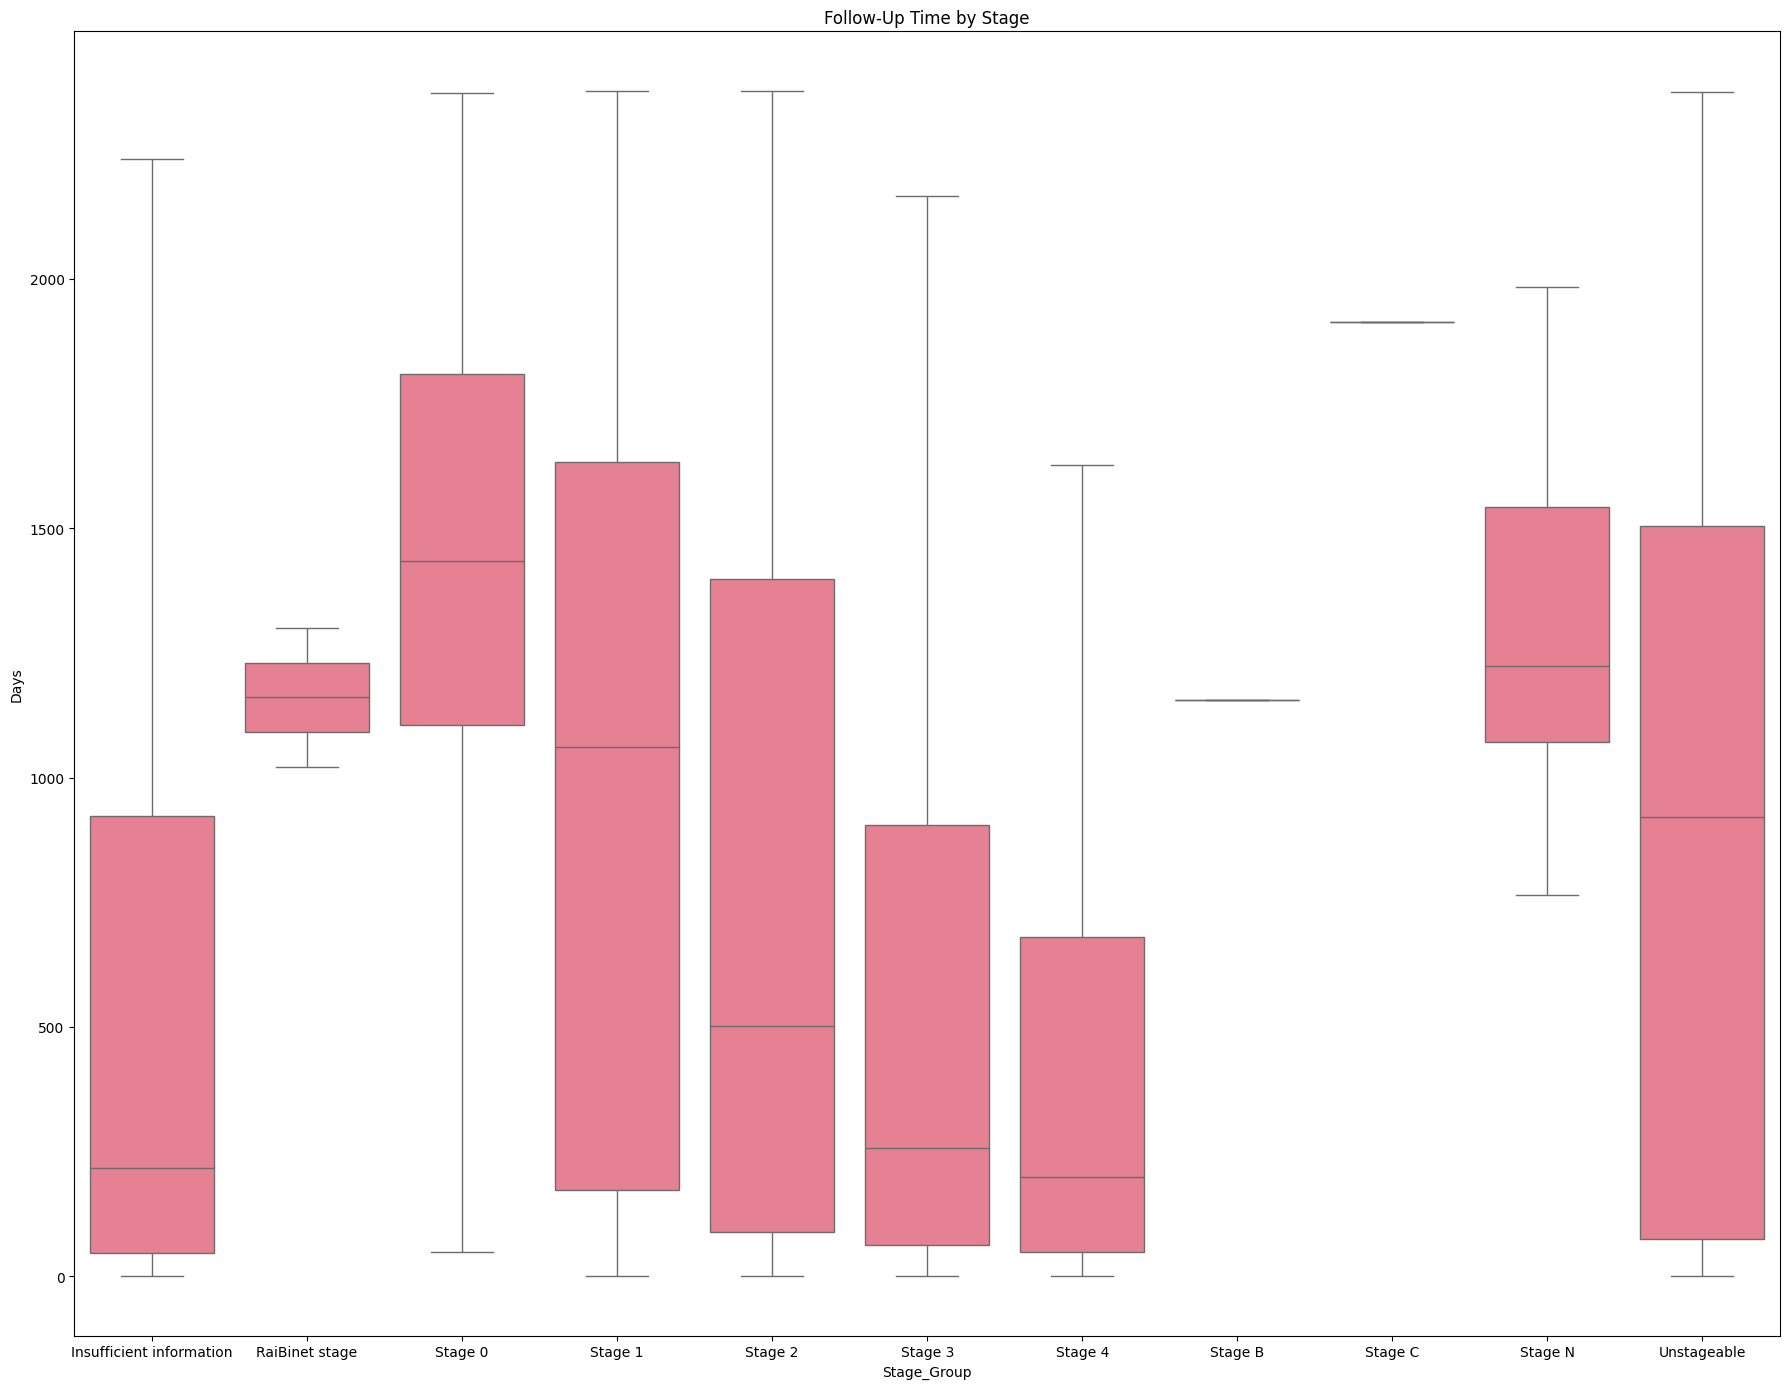

In [56]:
# Boxplot of follow-up days by Stage_Group
sns.boxplot(data=df_surv, x='Stage_Group', y='followup_days', showfliers=False, order=sorted(df_surv['Stage_Group'].unique()))
plt.title("Follow-Up Time by Stage")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

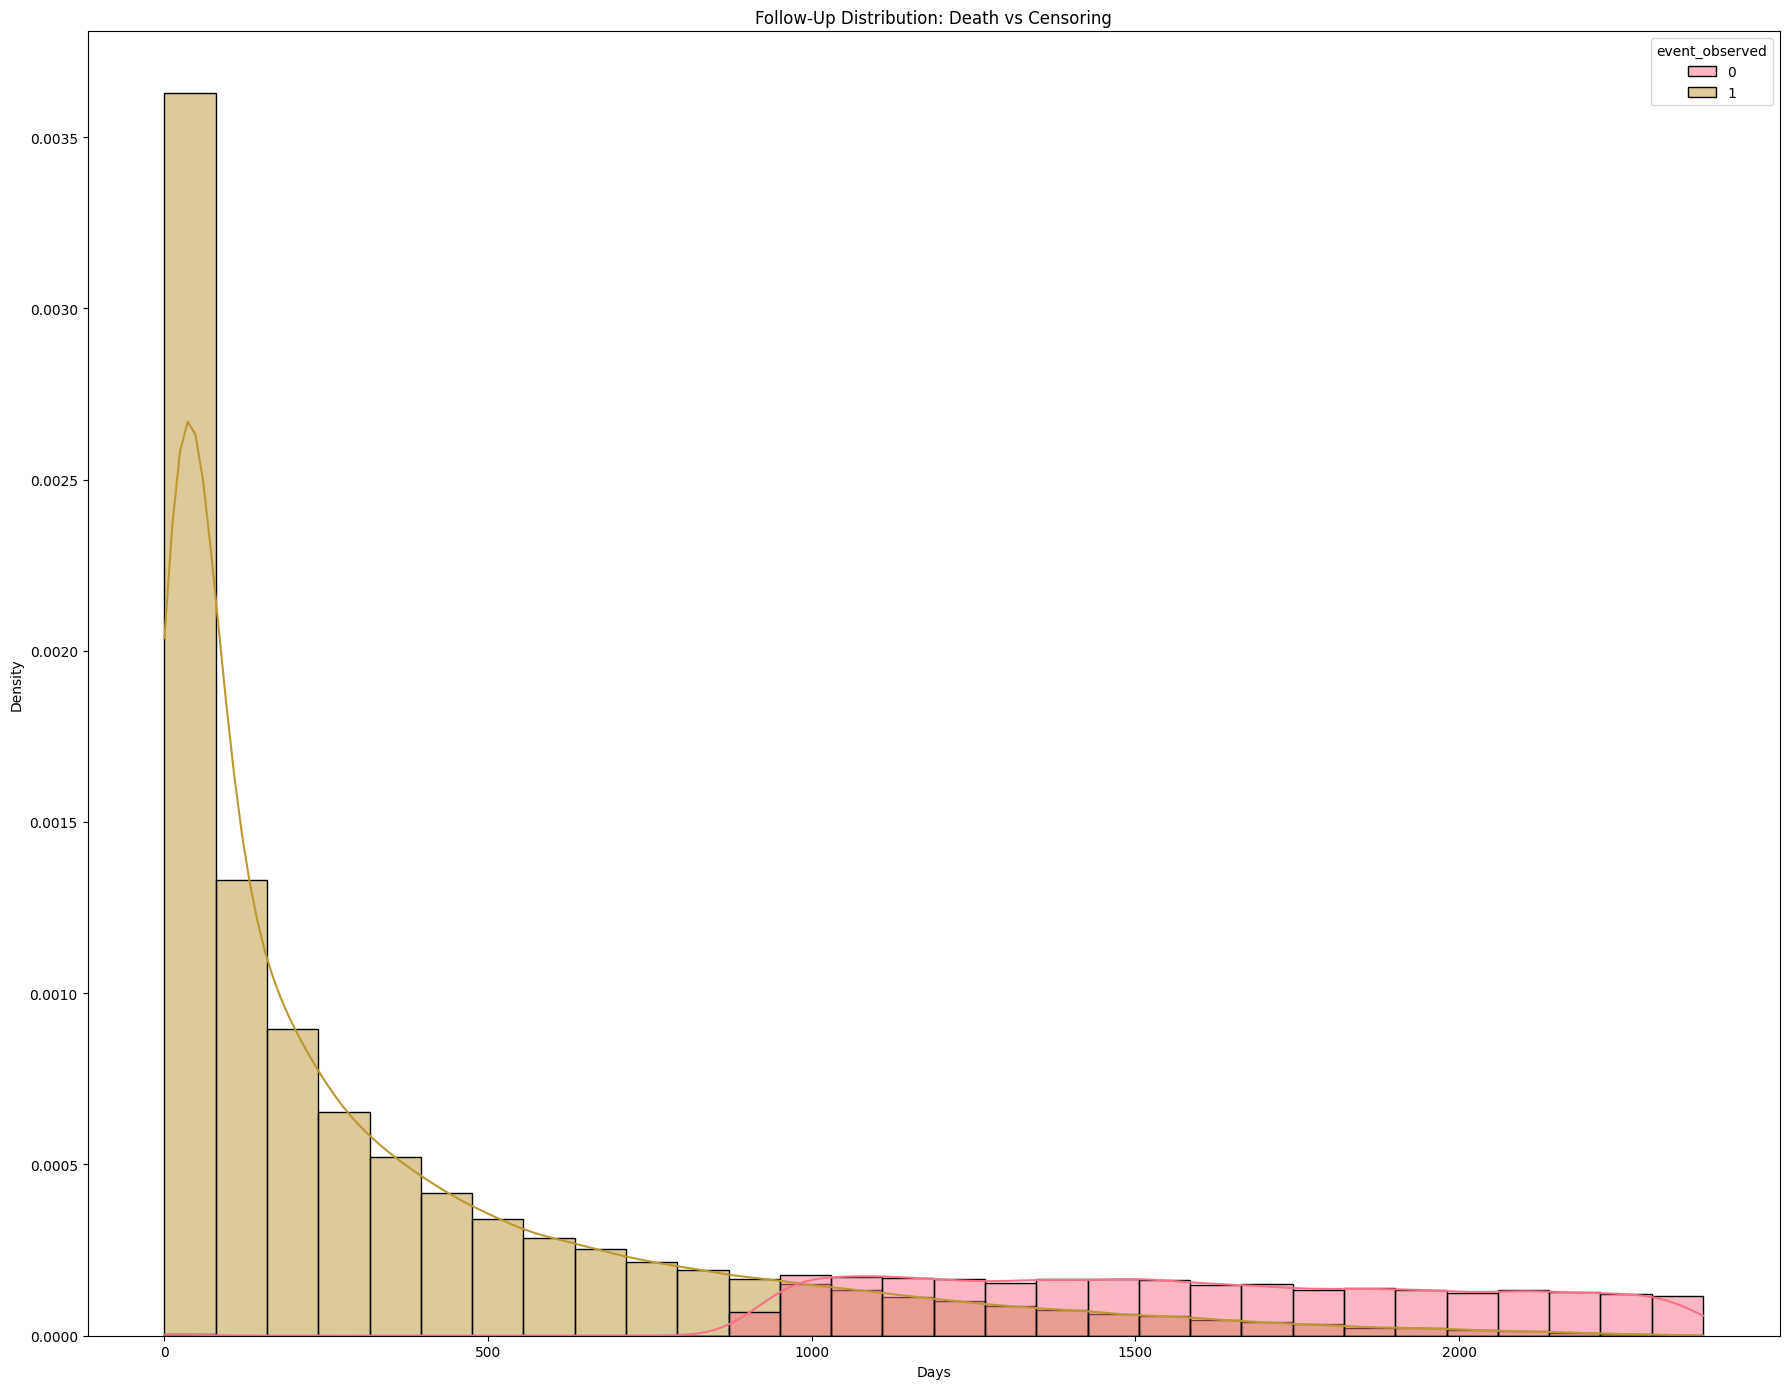

In [57]:
sns.histplot(data=df_surv, x='followup_days', hue='event_observed', bins=30, kde=True, stat="density")
plt.title("Follow-Up Distribution: Death vs Censoring")
plt.xlabel("Days")
plt.tight_layout()
plt.show()

### Stacked Bar Chart: Survival Outcome by Ethnicity

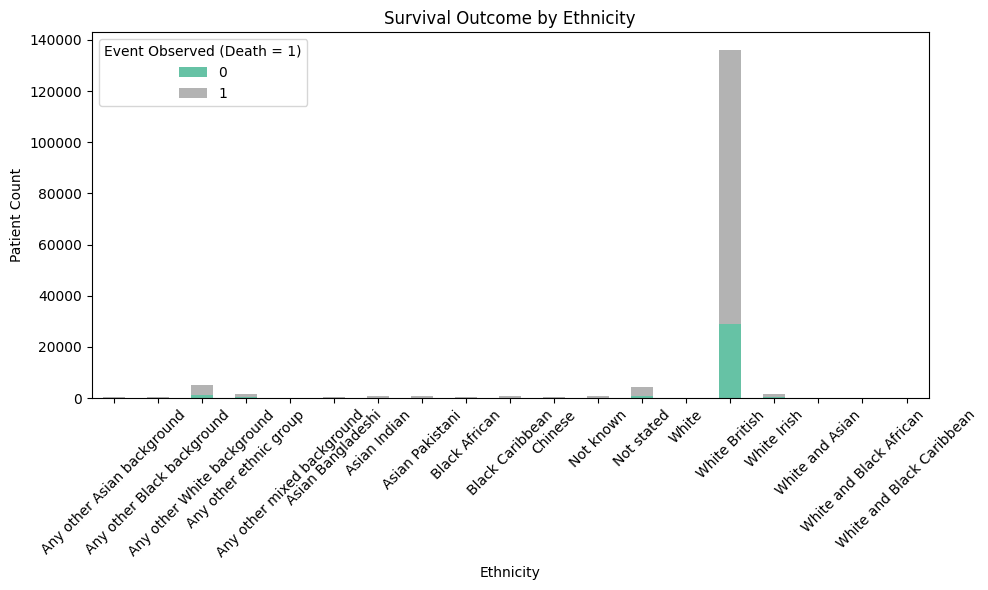

In [58]:
eth_counts = (df_lung
              .loc[:, ['ethnicity_label', 'event_observed']]
              .groupby(['ethnicity_label', 'event_observed'])
              .size()
              .unstack(fill_value=0)
              .sort_index())

eth_counts.plot(kind='bar',
                stacked=True,
                colormap='Set2',
                figsize=(10, 6))

plt.title("Survival Outcome by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Patient Count")
plt.xticks(rotation=45)
plt.legend(title="Event Observed (Death = 1)")
plt.tight_layout()
plt.show()


### SACT Uptake by Gender

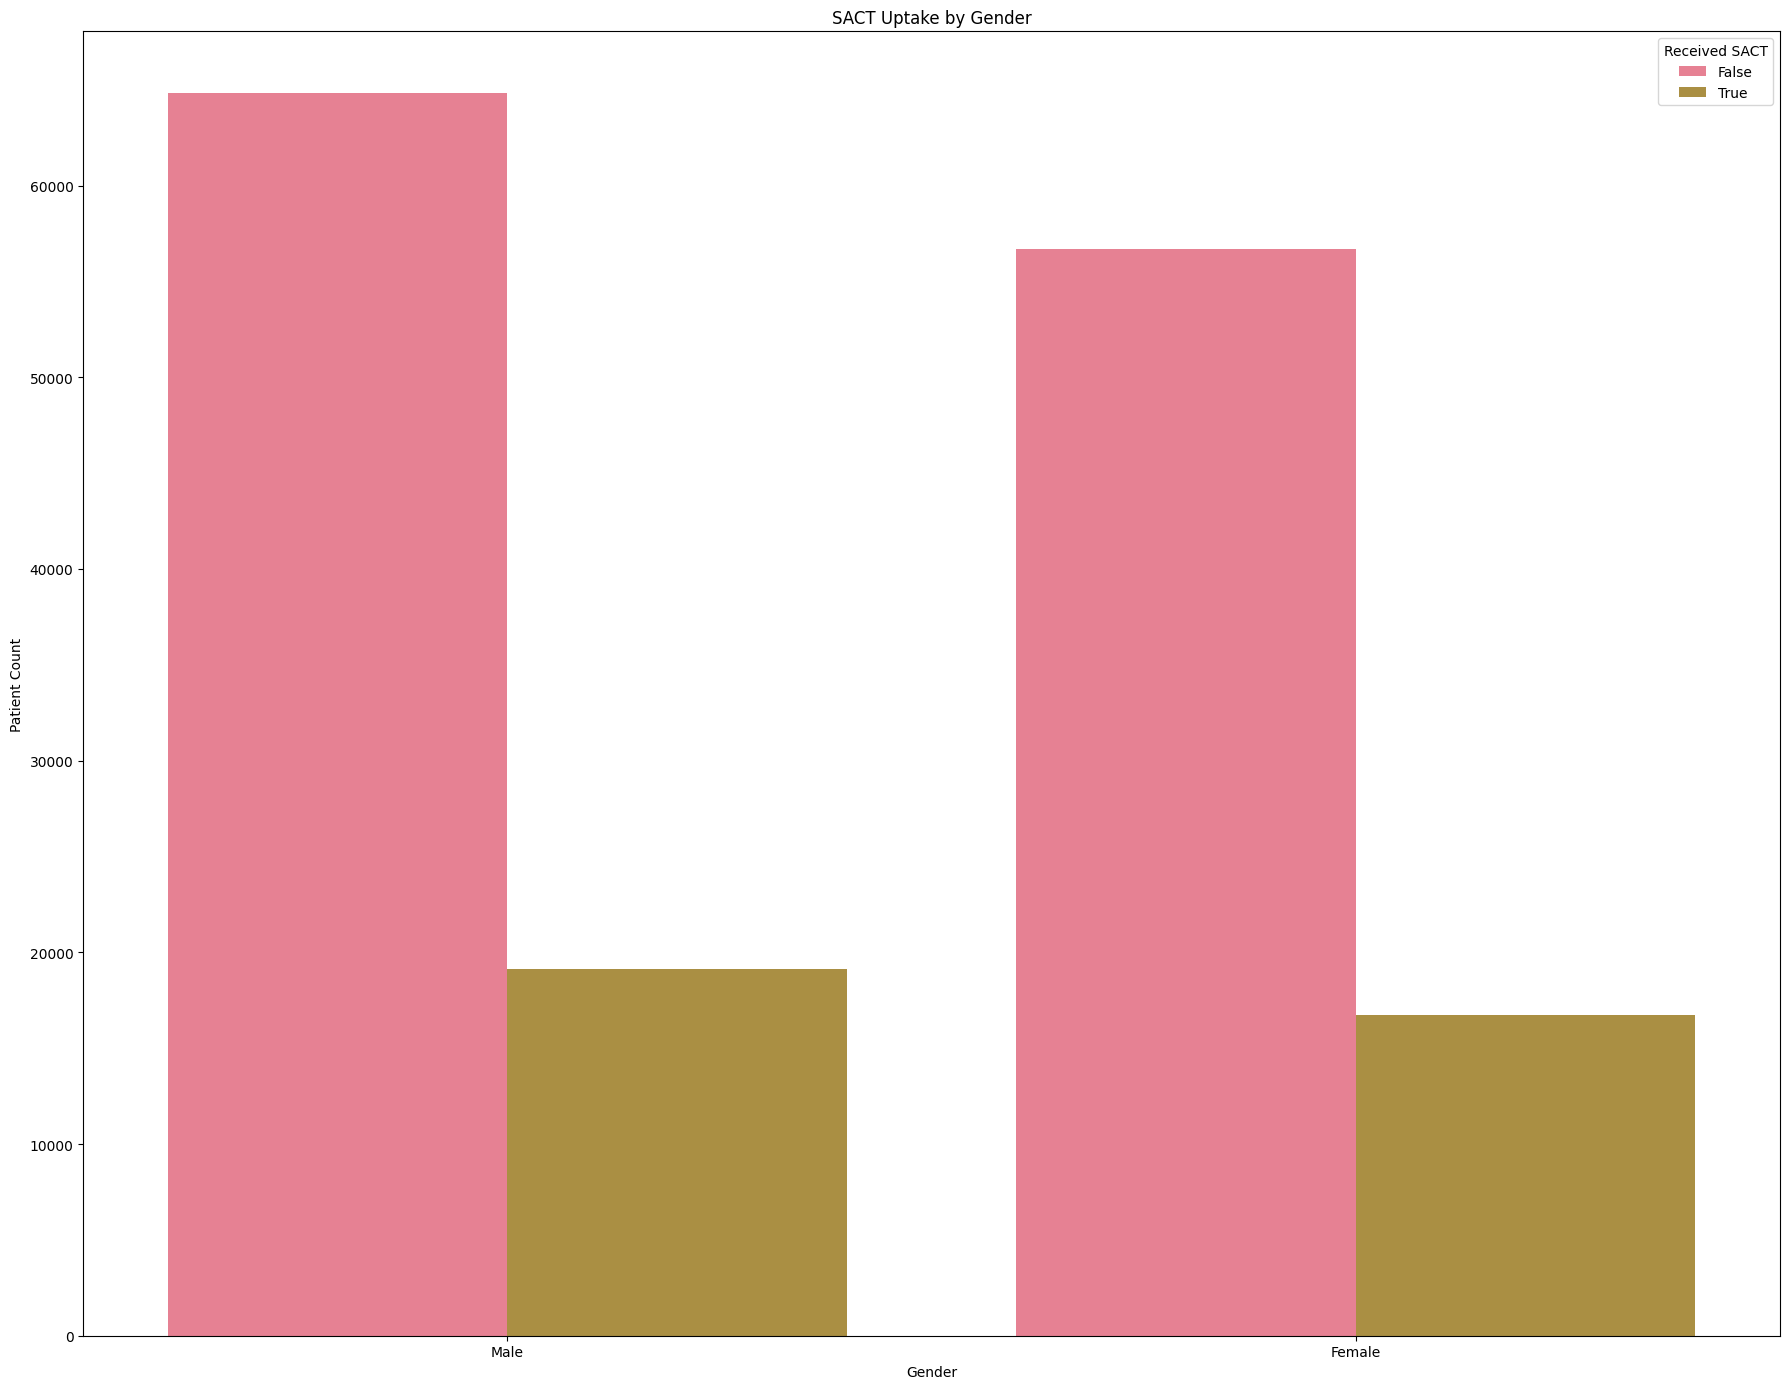

In [59]:
sns.countplot(data=df_lung,
              x='gender_label',
              hue='received_sact')
plt.title("SACT Uptake by Gender")
plt.xlabel("Gender")
plt.ylabel("Patient Count")
plt.legend(title="Received SACT")
plt.tight_layout()
plt.show()

### Kaplan–Meier Survival Curve

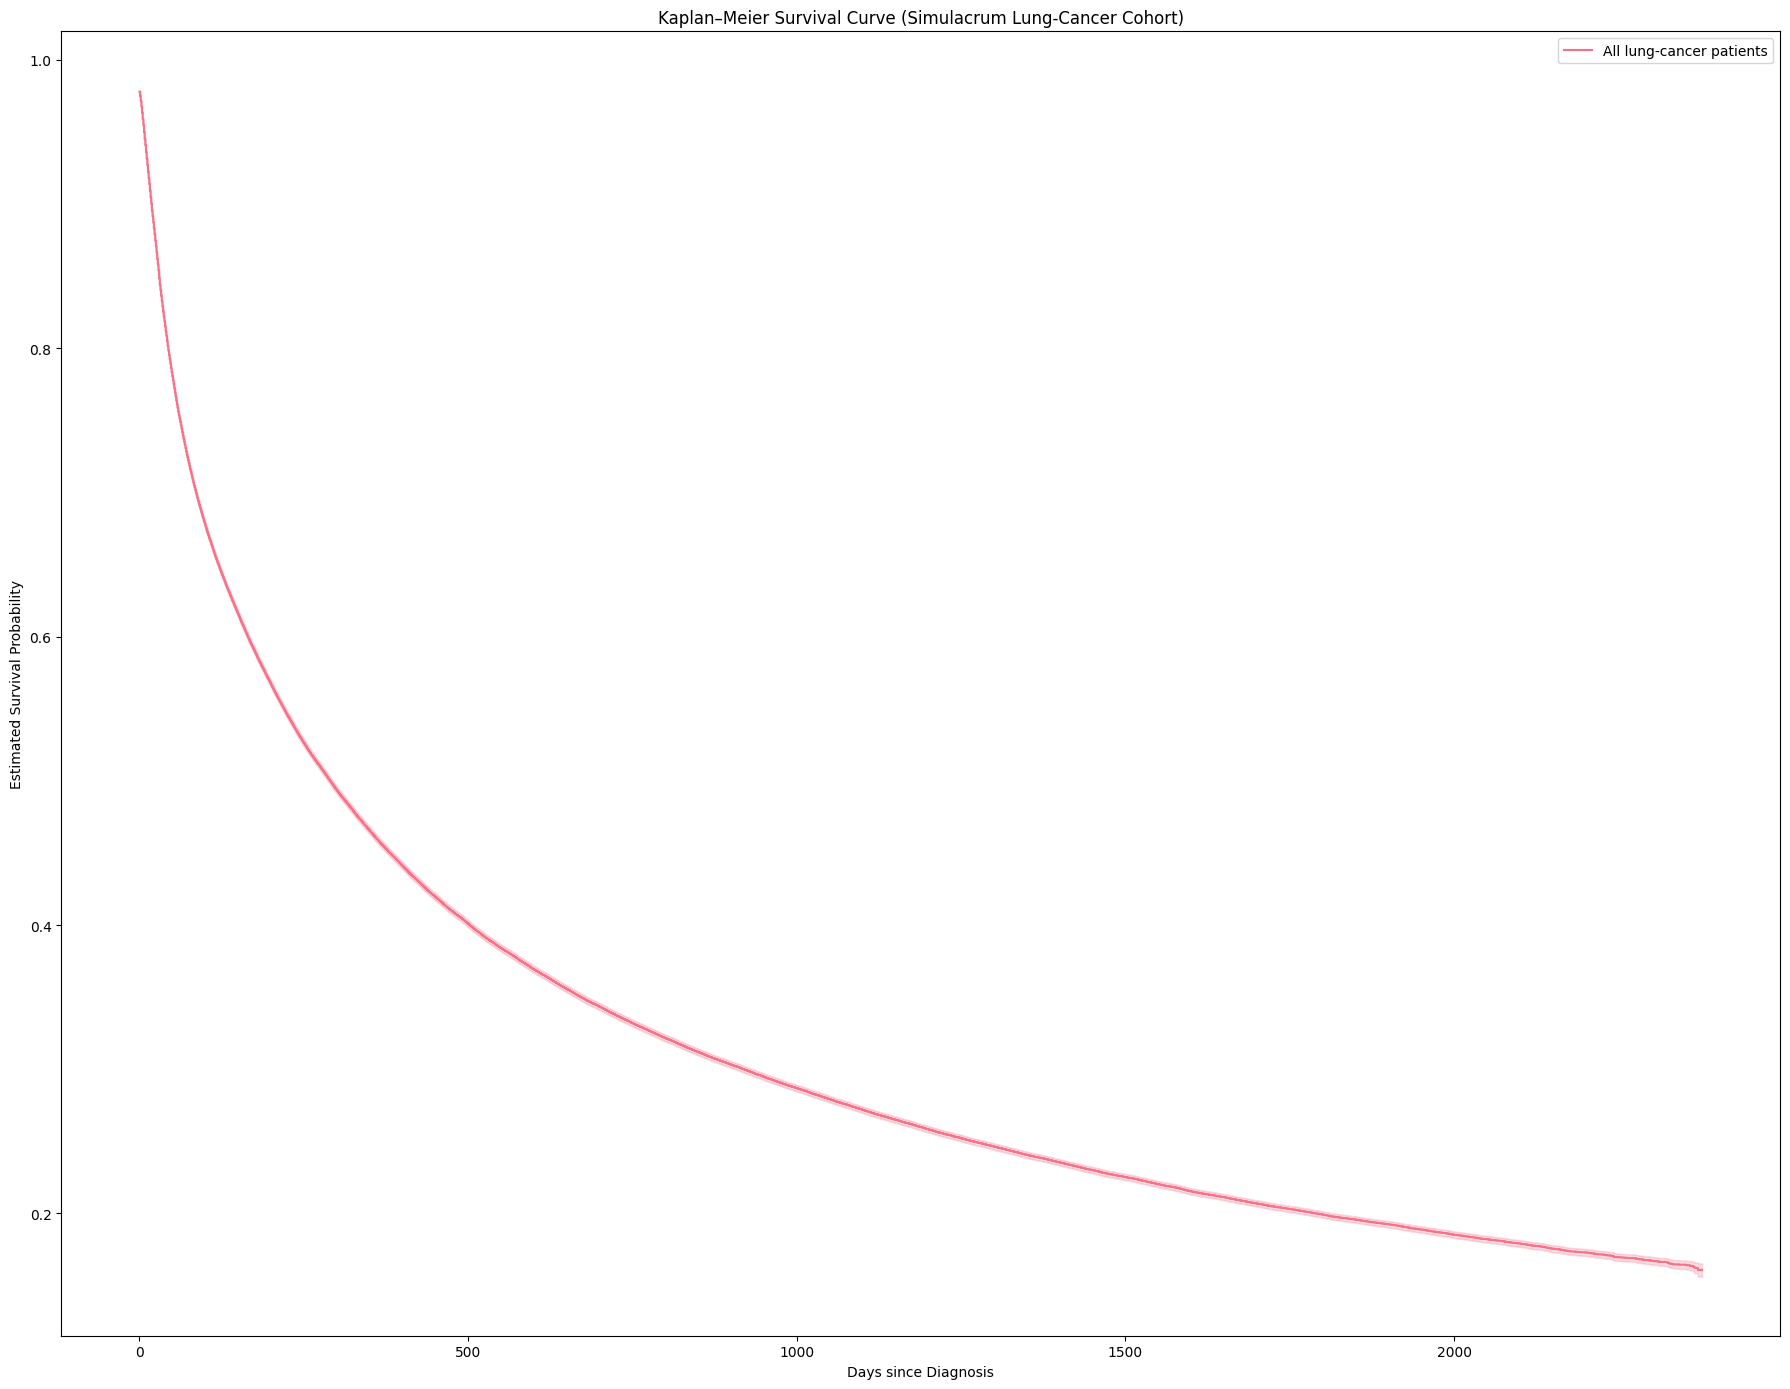

In [60]:
# Keep only rows with a valid follow-up time ≥ 0
df_surv = df_lung[df_lung['followup_days'].notna() & (df_lung['followup_days'] >= 0)]


kmf.fit(
    durations=df_surv['followup_days'],
    event_observed=df_surv['event_observed'],
    label="All lung-cancer patients"
)

kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curve (Simulacrum Lung-Cancer Cohort)")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Estimated Survival Probability")
plt.tight_layout()
plt.show()

# Save Dataframe to file

In [61]:
OUTPUT_PATH = "./c34_merged.csv"
df_lung.to_csv(OUTPUT_PATH, index=False)

In [72]:
df_lung.columns.tolist()

['PATIENTID',
 'GENDER_pt',
 'DEATHCAUSECODE_1A',
 'DEATHCAUSECODE_1B',
 'DEATHCAUSECODE_1C',
 'DEATHCAUSECODE_2',
 'DEATHCAUSECODE_UNDERLYING',
 'DEATHLOCATIONCODE',
 'VITALSTATUS',
 'VITALSTATUSDATE',
 'LINKNUMBER',
 'TUMOURID',
 'GENDER_tum',
 'DIAGNOSISDATEBEST',
 'SITE_ICD10_O2_3CHAR',
 'SITE_ICD10_O2',
 'SITE_ICD10R4_O2_3CHAR_FROM2013',
 'SITE_ICD10R4_O2_FROM2013',
 'SITE_ICDO3REV2011',
 'SITE_ICDO3REV2011_3CHAR',
 'MORPH_ICD10_O2',
 'MORPH_ICDO3REV2011',
 'BEHAVIOUR_ICD10_O2',
 'BEHAVIOUR_ICDO3REV2011',
 'T_BEST',
 'N_BEST',
 'M_BEST',
 'STAGE_BEST',
 'GRADE',
 'AGE',
 'CREG_CODE',
 'STAGE_BEST_SYSTEM',
 'LATERALITY',
 'SCREENINGSTATUSFULL_CODE',
 'ER_STATUS',
 'PR_STATUS',
 'HER2_STATUS',
 'QUINTILE_2019',
 'DATE_FIRST_SURGERY',
 'CANCERCAREPLANINTENT',
 'PERFORMANCESTATUS',
 'CHRL_TOT_27_03',
 'COMORBIDITIES_27_03',
 'GLEASON_PRIMARY',
 'GLEASON_SECONDARY',
 'GLEASON_TERTIARY',
 'GLEASON_COMBINED',
 'C34_source_col',
 'MERGED_REGIMEN_ID',
 'HEIGHT_AT_START_OF_REGIMEN',
 'WEIGH

# Streamlit

In [73]:
!pip install streamlit # lifelines plotly pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.3 MB/s eta 0:00:00


In [79]:
import os, pandas as pd, glob
print("CWD:", os.getcwd())
print("Exists ./c34_merged.csv?", os.path.exists("c34_merged.csv"))
print("Files here:", glob.glob("*"))

CWD: /content
Exists ./c34_merged.csv? True
Files here: ['simulacrum_v2.1.0.zip', 'drive', 'lt.log', 'app.py', 'simulacrum_v2.1.0', 'c34_merged.csv', 'streamlit.log', 'sample_data']


In [ ]:
!pip -q install streamlit lifelines plotly
!npm -g install localtunnel

In [81]:
%%writefile app.py

# app.py
# Streamlit dashboard for Simulacrum Lung Cancer (C34) using a merged patient-centric CSV (c34_merged.csv)

import os
import io
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import streamlit as st
from lifelines import KaplanMeierFitter

st.set_page_config(page_title="C34 Simulacrum Explorer", page_icon="🫁", layout="wide")

# ------------------------ Data utils ------------------------
@st.cache_data(show_spinner=False)
def load_csv(path_or_buffer):
    """Load CSV and coerce common date columns to datetime."""
    df = pd.read_csv(path_or_buffer)
    date_cols = [
        "DIAGNOSISDATEBEST", "VITALSTATUSDATE",
        "START_DATE_OF_REGIMEN", "DATE_DECISION_TO_TREAT",
        "DATE_OF_FINAL_TREATMENT", "APPTDATE",
        "DECISIONTOTREATDATE", "EARLIESTCLINAPPROPDATE"
    ]
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def ensure_fields(df: pd.DataFrame) -> pd.DataFrame:
    """
    Recompute survival fields and create fallbacks so the app is robust even if the CSV
    lacks some columns. This implements rec 3 (always recompute followup_days).
    """
    d = df.copy()

    # Stage group: prefer descriptive label, fall back to STAGE_BEST → "Stage X"
    if "Stage_Group" not in d.columns:
        if "stage_label" in d.columns:
            d["Stage_Group"] = d["stage_label"].fillna(
                d.get("STAGE_BEST", pd.Series(index=d.index)).astype(str).str[0].radd("Stage ")
            )
        elif "STAGE_BEST" in d.columns:
            d["Stage_Group"] = d["STAGE_BEST"].astype(str).str[0].radd("Stage ")
        else:
            d["Stage_Group"] = "Unknown"

    # Recompute survival fields (rec 3)
    # event_observed: 1 if death, else 0
    if "VITALSTATUS" in d.columns:
        d["event_observed"] = (d["VITALSTATUS"] == "D").astype(int)
    # followup_days: End - Start clipped at 0
    if {"DIAGNOSISDATEBEST", "VITALSTATUSDATE"}.issubset(d.columns):
        durations = (d["VITALSTATUSDATE"] - d["DIAGNOSISDATEBEST"]).dt.days
        d["followup_days"] = pd.to_numeric(durations, errors="coerce").clip(lower=0)
    else:
        d["followup_days"] = np.nan

    # Gene testing flag
    if "num_genes_tested" in d.columns:
        d["tested_group"] = np.where(d["num_genes_tested"].fillna(0) > 0, "Tested", "Not Tested")
    else:
        d["tested_group"] = "Unknown"

    # Treatment flags (fallbacks if not precomputed)
    if "received_sact" not in d.columns:
        if "MERGED_REGIMEN_ID" in d.columns:
            d["received_sact"] = d["MERGED_REGIMEN_ID"].notna()
        elif "INTENT_OF_TREATMENT" in d.columns:
            d["received_sact"] = d["INTENT_OF_TREATMENT"].notna()
        else:
            d["received_sact"] = False

    if "received_rt" not in d.columns:
        if "RADIOTHERAPYINTENT" in d.columns:
            d["received_rt"] = d["RADIOTHERAPYINTENT"].notna()
        else:
            d["received_rt"] = False

    # Age groups
    if "AGE" in d.columns:
        d["age_group"] = pd.cut(d["AGE"], bins=[0, 64, 74, 120],
                                labels=["<65", "65-74", "75+"], include_lowest=True)
    else:
        d["age_group"] = "Unknown"

    # Clean labels for display
    for col in ["gender_label", "ethnicity_label", "Stage_Group", "rt_label"]:
        if col in d.columns:
            d[col] = d[col].fillna("Unknown")

    return d

# ------------------------ KM robustness helpers (2A) ------------------------
def _km_mask(df: pd.DataFrame) -> pd.Series:
    """
    Valid KM rows: finite, non-negative durations and non-null event flags.
    This prevents NaNs from reaching lifelines (rec 2A).
    """
    if not {"followup_days", "event_observed"}.issubset(df.columns):
        return pd.Series(False, index=df.index)
    durations = pd.to_numeric(df["followup_days"], errors="coerce")
    events = pd.to_numeric(df["event_observed"], errors="coerce")
    return durations.notna() & events.notna() & (durations >= 0)

# ------------------------ UI helpers ------------------------
def kpi_tiles(df: pd.DataFrame):
    """KPIs; KM @ 1y computed with _km_mask (rec 2B)."""
    n_pat = df["PATIENTID"].nunique() if "PATIENTID" in df.columns else len(df)
    med_age = float(df["AGE"].median()) if "AGE" in df.columns else np.nan
    med_fu = float(df["followup_days"].median()) if "followup_days" in df.columns else np.nan

    one_year = np.nan
    mask = _km_mask(df)
    if mask.sum() >= 10:
        kmf = KaplanMeierFitter()
        kmf.fit(df.loc[mask, "followup_days"], event_observed=df.loc[mask, "event_observed"])
        try:
            one_year = float(kmf.predict(365.0))
        except Exception:
            one_year = np.nan

    c1, c2, c3, c4 = st.columns(4)
    c1.metric("Patients", f"{n_pat:,}")
    c2.metric("Median age", f"{med_age:.1f}" if not np.isnan(med_age) else "—")
    c3.metric("Median follow-up (days)", f"{med_fu:.0f}" if not np.isnan(med_fu) else "—")
    c4.metric("KM @ 1 year", f"{one_year:.2%}" if not np.isnan(one_year) else "—")

def count_bar(df, x, title, color=None, order=None):
    if x not in df.columns:
        st.info(f"Column '{x}' missing")
        return
    vc = df[x].fillna("Unknown").value_counts().reset_index()
    vc.columns = [x, "count"]
    if order is None:
        order = sorted(vc[x].tolist())
    fig = px.bar(vc, x=x, y="count", color=color, title=title,
                 category_orders={x: order})
    st.plotly_chart(fig, use_container_width=True)

def stacked_bar(df, x, y, title):
    if x not in df.columns or y not in df.columns:
        st.info(f"Need columns '{x}' and '{y}'")
        return
    tbl = (df[[x, y]].fillna("Unknown").groupby([x, y]).size()
           .reset_index(name="count"))
    fig = px.bar(tbl, x=x, y="count", color=y, barmode="stack", title=title)
    st.plotly_chart(fig, use_container_width=True)

def plot_km(df, group_col=None, title="Kaplan–Meier survival"):
    """KM plots using _km_mask for overall and per-group (rec 2C)."""
    mask_all = _km_mask(df)
    if mask_all.sum() < 10:
        st.info("Not enough valid rows for survival plot.")
        return

    kmf = KaplanMeierFitter()
    fig = go.Figure()

    if group_col and group_col in df.columns:
        for name, grp in df.groupby(group_col):
            m = _km_mask(grp)
            if m.sum() < 10:
                continue
            kmf.fit(grp.loc[m, "followup_days"], grp.loc[m, "event_observed"], label=str(name))
            sf = kmf.survival_function_.reset_index()
            fig.add_trace(go.Scatter(x=sf["timeline"], y=sf[kmf._label], mode="lines", name=str(name)))
    else:
        kmf.fit(df.loc[mask_all, "followup_days"], df.loc[mask_all, "event_observed"], label="All")
        sf = kmf.survival_function_.reset_index()
        fig.add_trace(go.Scatter(x=sf["timeline"], y=sf[kmf._label], mode="lines", name="All"))

    fig.update_layout(title=title, xaxis_title="Days since diagnosis",
                      yaxis_title="Survival probability")
    st.plotly_chart(fig, use_container_width=True)

def corr_heatmap(df):
    drop_ids = [c for c in ["PATIENTID", "LINKNUMBER", "LINK_NUMBER",
                            "MERGED_REGIMEN_ID", "PRESCRIPTIONID",
                            "RADIOTHERAPYEPISODEID"] if c in df.columns]
    num = df.drop(columns=drop_ids, errors="ignore").select_dtypes(include=np.number)
    num = num.loc[:, num.nunique() >= 2]  # drop constants
    if num.shape[1] < 2:
        st.info("Not enough numeric columns with variance for correlation.")
        return
    fig = px.imshow(num.corr(), text_auto=".2f",
                    color_continuous_scale="RdBu", zmin=-1, zmax=1,
                    title="Correlation heatmap (variance-filtered)")
    st.plotly_chart(fig, use_container_width=True)

# ------------------------ Load data with success banner ------------------------
st.sidebar.caption("Upload merged CSV (c34_merged.csv) or place it next to app.py.")
upl = st.sidebar.file_uploader("Upload CSV", type=["csv"])
default_path = "c34_merged.csv"

if upl is not None:
    df_raw = load_csv(upl)
    st.success(f"✅ Loaded uploaded file with {len(df_raw):,} rows.")
elif os.path.exists(default_path):
    df_raw = load_csv(default_path)
    st.success(f"✅ Loaded {default_path} with {len(df_raw):,} rows.")
else:
    st.error("❌ No CSV found. Upload in the sidebar or place ./c34_merged.csv next to app.py.")
    st.stop()

df = ensure_fields(df_raw)

# ------------------------ Sidebar filters ------------------------
with st.sidebar:
    st.header("Filters")

    if "Stage_Group" in df.columns:
        stages = sorted(df["Stage_Group"].dropna().unique().tolist())
        sel = st.multiselect("Stage", stages, default=stages)
        df = df[df["Stage_Group"].isin(sel)]

    if "age_group" in df.columns:
        ages = [x for x in df["age_group"].dropna().unique()]
        sel = st.multiselect("Age group", ages, default=ages)
        df = df[df["age_group"].isin(sel)]

    if "gender_label" in df.columns:
        gens = [x for x in df["gender_label"].dropna().unique()]
        sel = st.multiselect("Gender", gens, default=gens)
        df = df[df["gender_label"].isin(sel)]

    if "ethnicity_label" in df.columns:
        eth = [x for x in df["ethnicity_label"].dropna().unique()]
        sel = st.multiselect("Ethnicity", eth, default=eth)
        df = df[df["ethnicity_label"].isin(sel)]

    if "received_sact" in df.columns and st.checkbox("Only SACT recipients", value=False):
        df = df[df["received_sact"] == True]

    if "received_rt" in df.columns and st.checkbox("Only RT recipients", value=False):
        df = df[df["received_rt"] == True]

    q = st.text_input("Search PATIENTID contains", value="")
    if q and "PATIENTID" in df.columns:
        df = df[df["PATIENTID"].astype(str).str.contains(q, na=False)]

# ------------------------ Layout ------------------------
st.title("🫁 Simulacrum C34 (Lung) – Interactive Explorer")
st.caption("Patient-centric master table (synthetic). Use filters on the left to subset in real time.")

# KPIs (uses masked KM)
kpi_tiles(df)
st.divider()

tab1, tab2, tab3, tab4, tab5 = st.tabs(["Overview", "Treatments", "Survival", "Equity", "Quality"])

with tab1:
    c1, c2 = st.columns(2)
    with c1:
        count_bar(df, "Stage_Group", "Stage distribution")
    with c2:
        count_bar(df, "gender_label", "Gender distribution")

    c3, c4 = st.columns(2)
    with c3:
        count_bar(df, "ethnicity_label", "Ethnicity distribution")
    with c4:
        if "AGE" in df.columns:
            st.plotly_chart(px.histogram(df, x="AGE", nbins=30, title="Age at diagnosis", marginal="rug"),
                            use_container_width=True)

with tab2:
    if "received_sact" in df.columns:
        stacked_bar(df, "Stage_Group", "received_sact", "SACT uptake by stage")
    if "received_rt" in df.columns:
        stacked_bar(df, "Stage_Group", "received_rt", "Radiotherapy uptake by stage")
    if "rt_label" in df.columns and df.get("received_rt", pd.Series(False, index=df.index)).any():
        count_bar(df[df["received_rt"] == True], "rt_label", "Radiotherapy intent mix")

    # Time on treatment proxy
    if {"START_DATE_OF_REGIMEN", "DATE_OF_FINAL_TREATMENT"}.issubset(df.columns):
        tmp = df.dropna(subset=["START_DATE_OF_REGIMEN", "DATE_OF_FINAL_TREATMENT"]).copy()
        if not tmp.empty:
            tmp["time_on_tx"] = (tmp["DATE_OF_FINAL_TREATMENT"] - tmp["START_DATE_OF_REGIMEN"]).dt.days
            st.plotly_chart(px.box(tmp, x="Stage_Group", y="time_on_tx", points=False,
                                   title="Time on treatment (days) by stage"),
                            use_container_width=True)

with tab3:
    plot_km(df, None, "Overall survival")
    plot_km(df, "Stage_Group", "Survival by stage")
    if "tested_group" in df.columns:
        plot_km(df, "tested_group", "Survival by gene-testing status")

with tab4:
    if {"ethnicity_label", "event_observed"}.issubset(df.columns):
        tbl = (df[["ethnicity_label", "event_observed"]]
               .groupby(["ethnicity_label", "event_observed"]).size()
               .reset_index(name="count"))
        st.plotly_chart(px.bar(tbl, x="ethnicity_label", y="count", color="event_observed",
                               barmode="stack", title="Outcome by ethnicity (Death=1)"),
                        use_container_width=True)
    if {"gender_label", "received_sact"}.issubset(df.columns):
        stacked_bar(df, "gender_label", "received_sact", "SACT uptake by gender")

with tab5:
    corr_heatmap(df)
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    if not miss.empty:
        miss_fig = px.bar(miss.reset_index(), x="index", y=0,
                          title="Missingness by column",
                          labels={"index": "Column", "0": "Proportion missing"})
        miss_fig.update_layout(xaxis_tickangle=45)
        st.plotly_chart(miss_fig, use_container_width=True)

st.divider()
st.download_button("⬇️ Download filtered CSV",
                   df.to_csv(index=False).encode("utf-8"),
                   file_name="c34_filtered.csv", mime="text/csv")

Overwriting app.py


In [86]:
!curl -s https://ifconfig.me

34.23.189.189

In [84]:
# 1) Start Streamlit (background)
!nohup streamlit run app.py --server.headless true --server.address 0.0.0.0 --server.port 8501 > /content/streamlit.log 2>&1 &

# 2) Start localtunnel (background), request subdomain and log output
!nohup lt --port 8501 --subdomain c34-demo > /content/lt.log 2>&1 &

# 3) Print the URL from the log (random if subdomain not granted)
!grep -Eo "https://[a-zA-Z0-9-]+\.loca\.lt" -m1 /content/lt.log || echo "URL not ready yet; tail /content/lt.log"

https://purple-turtle-85.loca.lt


In [80]:
# # Graceful shutdown: ask whoever holds 8501/tcp to exit
# !fuser -k 8501/tcp || true

# # Verify
# !ss -ltnp | grep 8501 || echo "Port 8501 is free."

8501/tcp:            13919
Port 8501 is free.


# Version TC C34

In [62]:
GROUP_8_PATH = '/content/drive/My Drive/Group8_TC_C34_v2_Data'

In [63]:
df_sim_av_patient = pd.read_csv(GROUP_8_PATH+'/sim_av_patient_c34.csv')

In [64]:
df_sim_av_patient.head()

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,LINKNUMBER
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101115525
1,10175273,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101155391
2,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101574796
3,10175292,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,100834633
4,10175333,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,100951264


In [65]:
df_sim_av_gene = pd.read_csv(GROUP_8_PATH+'/sim_av_gene_c34.csv')

In [66]:
df_sim_av_gene.head()

,GENEID,TUMOURID,PATIENTID,GENE_DESC,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,ALL_TESTSTATUSES,OVERALL_TS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10037483,11641162,10243109,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-01-22,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,10037484,11723811,10243117,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-03-25,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,10037492,11502311,10243418,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-26,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,10037495,10073014,10243465,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-05-15,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,10037528,10014582,10244392,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-12,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [67]:
df_sim_av_gene.describe()

,GENEID,TUMOURID,PATIENTID,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,NO_OF_AB_GATS,NO_OF_SEQ_VARS,NO_OF_PRO_IMPS
count,1.006890e+05,1.006890e+05,1.006890e+05,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000
mean,1.006210e+08,1.100121e+07,1.005732e+08,1503.639126,1.092562,1.228913,1.058974,0.149947,0.034443,0.039567
std,1.189183e+07,5.785224e+05,1.189137e+07,2210.732603,0.424913,0.594973,0.333099,0.358188,0.202885,0.235377
min,1.003748e+07,1.000012e+07,1.017521e+07,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000248e+08,1.049507e+07,1.000084e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000618e+08,1.100333e+07,1.000194e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.001025e+08,1.150246e+07,1.000291e+08,4842.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.500091e+08,1.199998e+07,2.500025e+08,5037.000000,23.000000,23.000000,23.000000,2.000000,4.000000,5.000000


In [68]:
df_patient_gene = pd.merge(df_sim_av_patient, df_sim_av_gene, on='PATIENTID', how='left')

In [69]:
df_patient_gene

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,...,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10175206,1,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,Bristol (molecular lab)
1,10175273,1,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,10175282,1,Z,NaN,NaN,...,NaN,0.0,NaN,NaN,Newcastle (molecular lab)
3,10175282,1,Z,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN
4,10175292,1,Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
214784,250002505,2,A,C445,NaN,...,NaN,0.0,NaN,NaN,NaN
214785,250002507,2,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
214786,250002519,2,J,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
214787,250002530,1,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [70]:
# Check the result
print(f"Original patient records: {len(df_sim_av_patient)}")
print(f"Original gene records: {len(df_sim_av_gene)}")
print(f"Combined records: {len(df_patient_gene)}")
print(f"Combined columns: {len(df_patient_gene.columns)}")

Original patient records: 157354
Original gene records: 100689
Combined records: 214789
Combined columns: 40


In [71]:
print(df_patient_gene.columns)

Index(['PATIENTID', 'GENDER', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
       'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS',
       'VITALSTATUSDATE', 'LINKNUMBER', 'GENEID', 'TUMOURID', 'GENE_DESC',
       'GENE', 'COUNT_TESTS', 'COUNT_RESULTS', 'COUNT_DATE',
       'ALL_TESTSTATUSES', 'OVERALL_TS', 'NO_OF_AB_GATS', 'DNASEQ_GAT',
       'METHYL_GAT', 'EXP_GAT', 'COPYNO_GAT', 'FUS_TRANS_GAT', 'ABNORMAL_GAT',
       'NO_OF_SEQ_VARS', 'ALL_SEQ_VARS', 'SEQ_VAR', 'DATE_OVERALL_TS',
       'BEST_DATE_SOURCE_OVERALL_TS', 'MIN_DATE', 'MAX_DATE', 'ALL_PRO_IMPS',
       'NO_OF_PRO_IMPS', 'PRO_IMP', 'METHODS', 'LAB_NAME'],
      dtype='object')
